In [ ]:
import pandas as pd
from glob import glob
import os
import re
from plotnine import *
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# sample data

In [ ]:
# read sample tables and library tables
physical_samples_df = pd.read_csv('/content/drive/My Drive/UC Berkeley/IAV_seq_results/physical_samples.csv', sep=',',keep_default_na=False)
libraries_df = pd.read_csv('/content/drive/My Drive/UC Berkeley/IAV_seq_results/Libraries.csv', sep=',',keep_default_na=False)
physical_samples_df = physical_samples_df.rename(columns={'Target':'strain'})

# merge physical samples and library information
samples_libraries_df = libraries_df.merge(physical_samples_df, on='sample_id', how='left')
samples_libraries_df['sample_name'] = samples_libraries_df.sample_id + "_" + samples_libraries_df.library_id.astype('string')
samples_libraries_df=samples_libraries_df[['sample_name', 'sample_id', 'library_id', 'WW_method', 'strain', 'dPCR_postFreeze_thaw_gc_ul','sequencing_method']]
print(samples_libraries_df['library_id'].unique())
print(samples_libraries_df['library_id'].nunique())

# read virus info including strains, segments, accessions.
strains_df = pd.read_csv('/content/drive/My Drive/UC Berkeley/IAV_seq_results/All_strain_accessions.csv', keep_default_na=False)
strains_df = strains_df.fillna("NA")

['40' '41' '43' '44' '45' '46' '47' '48' '22' '23' '24' '25' '26' '27'
 '28' '29' '30' '65' '66' '67' '68' '69' '70' '71' '72' '10' '11' '12'
 '13' '14' '15' '16' '17' '18' '20' '57' '58' '59' '60' '61' '62' '63'
 '64' '1' '2' '3' '4' '5' '6' '7' '8' '9' '19' '49' '50' '51' '52' '53'
 '54' '55' '56' '21' 'M3' '31' '32' '33' '34' '35' '36' '37' '38' '39'
 '81' '82' '83' '84' '85' '86' '87' '88']
80


# Read count data

In [ ]:
# Sample 4 read count data is rerun against the gBlock, results are separately stored
reads_S4 = []
for f in glob('/content/drive/My Drive/UC Berkeley/IAV_seq_results/Sample4/reads_stats/stats*.txt'):
    step = os.path.basename(f).split('.')[0]
    df = pd.read_csv(f, sep='\t')
    df['step'] = step
    df['library_id'] = df.file.str.extract(r'([\d\w]+)_S.*')
    #df.loc[df.library_id.isna(), 'library_id'] = 'ntc'
    reads_S4.append(df)
reads_S4 = pd.concat(reads_S4)

# Data clean-up
replacement_dict = {'DM_IAV_1E4_gBlock': '19','UCB_WW_Twist_20': '20'}
reads_S4['library_id'] = reads_S4['library_id'].replace(replacement_dict)
reads_S4['step'] = reads_S4['step'].replace({"stats_fastq":"stats_fastp"})
reads_S4.loc[reads_S4['library_id'].isin(["20"]), 'methods'] = 'Twist_comprehensive'
reads_S4.loc[reads_S4['library_id'].isin(["19"]), 'methods'] = 'Twist_IAV'
print(reads_S4['step'].unique())
reads_S4.head()

['stats_paired' 'stats_dedupe' 'stats_fastp' 'stats_raw']


file format type  num_seqs  \
0  /p/lustre1/preview/IAV_seq_data/sample_4/step_...  FASTQ  DNA   1722371   
1  /p/lustre1/preview/IAV_seq_data/sample_4/step_...  FASTQ  DNA   1147974   
2  /p/lustre1/preview/IAV_seq_data/sample_4/step_...  FASTQ  DNA   1722371   
3  /p/lustre1/preview/IAV_seq_data/sample_4/step_...  FASTQ  DNA   1837871   
4  /p/lustre1/preview/IAV_seq_data/sample_4/step_...  FASTQ  DNA    919166   

     sum_len  min_len  avg_len  max_len          step library_id  \
0  385298515       75    223.7      301  stats_paired         19   
1  255862974       75    222.9      301  stats_paired         19   
2  385426477       75    223.8      301  stats_paired         19   
3  447036359       75    243.2      301  stats_paired         19   
4  124661397       75    135.6      151  stats_paired         20   

               methods  
0            Twist_IAV  
1            Twist_IAV  
2            Twist_IAV  
3            Twist_IAV  
4  Twist_comprehensive

In [ ]:
# Nanopore read count data
reads_nano = []
for f in glob('/content/drive/My Drive/UC Berkeley/IAV_seq_results/nanopore/stats*.txt'):
    step = os.path.basename(f).split('.')[0]
    df = pd.read_csv(f, sep='\t')
    df['step'] = step
    df['library_id'] = df.file.str.extract(r'UCB_IAV_([\d\w]+)_S.*')
    #df.loc[df.library_id.isna(), 'library_id'] = 'ntc'
    reads_nano.append(df)
reads_nano = pd.concat(reads_nano)

# Data clean-up
reads_nano['methods']='Universal-amplicon'
reads_nano=reads_nano[~reads_nano['library_id'].isin(["NTC"])]
print(reads_nano['library_id'].unique())

['31' '32' '33' '34' '35' '36' '37' '38' '39' '81' '82' '83' '84' '85'
 '86' '87' '88']


In [ ]:
# read in each read stats file from seqkit stats
reads_comp = []
for f in glob('/content/drive/My Drive/UC Berkeley/IAV_seq_results/Twist_comp/reads_stats/stats*.txt'):
    step = os.path.basename(f).split('.')[0]
    df = pd.read_csv(f, sep='\t')
    df['step'] = step
    df['library_id'] = df.file.str.extract(r'UCB_WW_Twist_([\d\w]+)_S.*')
    #df.loc[df.library_id.isna(), 'library_id'] = 'ntc'
    reads_comp.append(df)
reads_comp = pd.concat(reads_comp)
reads_comp['methods']='Twist_comprehensive'
# exclude 20 (sample 4) because it's read from the above script
reads_comp = reads_comp[~reads_comp['library_id'].isin(['20'])]
reads_comp.head()

file format type  num_seqs  \
0  /p/vast1/preview/241122_VH00179_91_twist_ucb_w...  FASTQ  DNA   1400688   
1  /p/vast1/preview/241122_VH00179_91_twist_ucb_w...  FASTQ  DNA   1400688   
2  /p/vast1/preview/241122_VH00179_91_twist_ucb_w...  FASTQ  DNA   1444589   
3  /p/vast1/preview/241122_VH00179_91_twist_ucb_w...  FASTQ  DNA   1444589   
4  /p/vast1/preview/241122_VH00179_91_twist_ucb_w...  FASTQ  DNA   1357348   

     sum_len  min_len  avg_len  max_len       step library_id  \
0  176220957       35    125.8      151  stats_raw         10   
1  182418004       35    130.2      151  stats_raw         10   
2  179738077       35    124.4      151  stats_raw         11   
3  186548269       35    129.1      151  stats_raw         11   
4  171304155       35    126.2      151  stats_raw         12   

               methods  
0  Twist_comprehensive  
1  Twist_comprehensive  
2  Twist_comprehensive  
3  Twist_comprehensive  
4  Twist_comprehensive

In [ ]:
# read in each read stats file from seqkit stats
reads_IAV = []
for f in glob('/content/drive/My Drive/UC Berkeley/IAV_seq_results/Twist_IAV/read_stats/stats*.txt'):
    step = os.path.basename(f).split('.')[0]
    df = pd.read_csv(f, sep='\t')
    df['step'] = step
    df['library_id'] = df.file.str.extract(r'([\d\w]+)_S.*')
    #df.loc[df.library_id.isna(), 'library_id'] = 'ntc'
    reads_IAV.append(df)
reads_IAV = pd.concat(reads_IAV)

# Dataframe clean-up
reads_IAV['methods']='Twist_IAV'
replacement_dict = {'DM_IAV_1E2_1': "1",'DM_IAV_1E2_2': "2",'DM_IAV_1E2_3': '3','DM_IAV_1E3_1': '4',
                    'DM_IAV_1E3_2': '5','DM_IAV_1E4_3': '9','DM_IAV_1E4_gBlock': '19','Found_Index1': '8',
                    'Found_Index2': "7",'Found_Index3': "6",'IP_IAV_0': '49','IP_IAV_1': '50','IP_IAV_2': '51',
                    'IP_IAV_3': '52','PMG_IAV_0': '53','PMG_IAV_1': '54','PMG_IAV_3': '56','21_unenriched_1E4' :"21",'M3_stock':"M3"}
reads_IAV['library_id'] = reads_IAV['library_id'].replace(replacement_dict)
reads_IAV.loc[reads_IAV['library_id'].isin(["21", 'M3']), 'methods'] = 'unenriched'

# Remove the empty data with the wrong index
reads_IAV = reads_IAV[~reads_IAV['library_id'].isin(['DM_IAV_1E3_3', 'DM_IAV_1E4_1', 'DM_IAV_1E4_2', 'Found_Index4','DM_IAV_1E4_gBlock'])]
print(reads_IAV["library_id"].unique())

['21' '1' '2' '3' '4' '5' '9' '8' '7' '6' '49' '50' '51' '52' 'M3' '53'
 '54' '56']


In [ ]:
# read in each read stats file from seqkit stats
reads_tiled = []
for f in glob('/content/drive/My Drive/UC Berkeley/IAV_seq_results/Tiled_amplicon/read_stats/stats*.txt'):
    step = os.path.basename(f).split('.')[0]
    df = pd.read_csv(f, sep='\t')
    df['step'] = step
    df['library_id'] = df.file.str.extract(r'([\d\w]+)_(?:DM|PMG|IP)')
    #df.loc[df.library_id.isna(), 'library_id'] = 'ntc'
    reads_tiled.append(df)
reads_tiled = pd.concat(reads_tiled)

# Data clean-up, remove the human removed data, the cutadapt is directly ran after fastp now
reads_tiled = reads_tiled[~reads_tiled['step'].isin(['stats_human_removed'])]
reads_tiled['methods']='Tiled-amplicon'
reads_tiled.head()
print(reads_tiled["step"].unique())

['stats_raw' 'stats_fastp' 'stats_cutadapt']


In [ ]:
final = pd.concat([reads_nano,reads_comp, reads_IAV, reads_tiled, reads_S4])
final.to_csv("/content/drive/My Drive/UC Berkeley/IAV_seq_results/summary_read_stats.csv")
print(final["library_id"].unique())
print(final["library_id"].nunique())
final.head()
# Total 72 samples, including Twist_IAV, Twist_comp, unenriched, M3, Tiled-amplicon, NTC (from twist_comp), sample4 (19,20), universal amplicon
# Didn't include targeted amplicon (40-48), and universal-amplicon NTC

['31' '32' '33' '34' '35' '36' '37' '38' '39' '81' '82' '83' '84' '85'
 '86' '87' '88' '10' '11' '12' '13' '14' '15' '16' '17' '18' '57' '58'
 '59' '60' '61' '62' '63' '64' 'NTC' '21' '1' '2' '3' '4' '5' '9' '8' '7'
 '6' '49' '50' '51' '52' 'M3' '53' '54' '56' '22' '23' '24' '25' '26' '27'
 '28' '29' '30' '65' '66' '67' '68' '69' '70' '71' '72' '19' '20']
72


file format type  num_seqs  \
0  /p/vast1/preview/20241115_UCB_IAV_hac/UCB_IAV_...  FASTQ  DNA    433356   
1  /p/vast1/preview/20241115_UCB_IAV_hac/UCB_IAV_...  FASTQ  DNA    682858   
2  /p/vast1/preview/20241115_UCB_IAV_hac/UCB_IAV_...  FASTQ  DNA    332966   
3  /p/vast1/preview/20241115_UCB_IAV_hac/UCB_IAV_...  FASTQ  DNA    594450   
4  /p/vast1/preview/20241115_UCB_IAV_hac/UCB_IAV_...  FASTQ  DNA    473918   

     sum_len  min_len  avg_len  max_len       step library_id  \
0  148463887        1    342.6     6753  stats_raw         31   
1  297336572        1    435.4     6723  stats_raw         32   
2  143394899        1    430.7     5616  stats_raw         33   
3  238578342        1    401.3   132486  stats_raw         34   
4  195861834        1    413.3    35021  stats_raw         35   

              methods  
0  Universal-amplicon  
1  Universal-amplicon  
2  Universal-amplicon  
3  Universal-amplicon  
4  Universal-amplicon

In [ ]:
# 1) Select only the two columns from dataframe `final`
out = final[['file', 'library_id','step']].copy()

# 2) Order rows by your custom library order
lib_order = """
31 32 33 34 35 36 37 38 39 81 82 83 84 85 86 87 88
22 23 24 25 26 27 28 29 30 65 66 67 68 69 70 71 72
10 11 12 13 14 15 16 17 18 20 57 58 59 60 61 62 63 64
1 2 3 4 5 6 7 8 9 19 49 50 51 52 53 54 55 56 21 M3
""".split()

out['library_id'] = out['library_id'].astype(str)
out = out[out['library_id'].isin(lib_order)]
out['library_id'] = out['library_id'].astype(pd.CategoricalDtype(categories=lib_order, ordered=True))
out = out.sort_values('library_id').reset_index(drop=True)
out = out[out['step']=='stats_raw']
out.to_csv('/content/drive/My Drive/UC Berkeley/IAV_seq_results/library_order.csv', index=False)
out.head()

file library_id       step
0  /p/vast1/preview/20241115_UCB_IAV_hac/UCB_IAV_...         31  stats_raw
2  /p/vast1/preview/20241115_UCB_IAV_hac/UCB_IAV_...         32  stats_raw
4  /p/vast1/preview/20241115_UCB_IAV_hac/UCB_IAV_...         33  stats_raw
6  /p/vast1/preview/20241115_UCB_IAV_hac/UCB_IAV_...         34  stats_raw
8  /p/vast1/preview/20241115_UCB_IAV_hac/UCB_IAV_...         35  stats_raw

In [ ]:
reads_sum = final.groupby(['library_id', 'step','methods']).aggregate({'num_seqs':'sum',
                                                    'sum_len':'sum',
                                                    'min_len':'min',
                                                    'avg_len':'mean'}).reset_index()
reads_sum.rename(columns={'methods': 'sequencing_method'}, inplace=True)

# NOTES: here use sum_len instead of num_seqs for following normalization
# so in reads_sum_wide is the sum of reads len after each step
#reads_sum_wide = reads_sum.pivot(index='library_id', columns='step', values='sum_len').reset_index()
reads_sum_wide = reads_sum.pivot(index='library_id', columns='step', values='num_seqs').reset_index()
reads_sum_wide_2= reads_sum.pivot(index='library_id', columns='step', values='sum_len').reset_index()
# fix names of steps
reads_sum_wide.columns = ['library_id', 'cutadapt','deduplicated', 'filtered', 'paired', 'raw']
reads_sum_wide_2.columns = ['library_id', 'cutadapt','deduplicated', 'filtered', 'paired', 'raw']
print(reads_sum_wide["library_id"].unique())
print(reads_sum_wide["library_id"].nunique())
#print(reads_sum_wide["sequencing_methods"].nunique())
reads_sum_wide.head()
# Already checked, the summary is good
#check=reads_sum_wide[reads_sum_wide['paired'].isna()]
#print(check['library_id'].unique())
# save for Supplementary Tables
reads_sum_wide_2.to_csv('/content/drive/My Drive/UC Berkeley/IAV_seq_results/summary_reads_len_wide.csv', index=False)
reads_sum_wide.to_csv('/content/drive/My Drive/UC Berkeley/IAV_seq_results/summary_reads_num_wide.csv', index=False)
reads_sum_wide.head()

['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '22'
 '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35' '36'
 '37' '38' '39' '4' '49' '5' '50' '51' '52' '53' '54' '56' '57' '58' '59'
 '6' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '7' '70' '71' '72'
 '8' '81' '82' '83' '84' '85' '86' '87' '88' '9' 'M3' 'NTC']
72


library_id  cutadapt  deduplicated    filtered     paired         raw
0          1       NaN     5517910.0  22797958.0  5517910.0  22861868.0
1         10       NaN     1416479.0   2527132.0  1416479.0   2801376.0
2         11       NaN     1375298.0   2566290.0  1375298.0   2889178.0
3         12       NaN     1389997.0   2449794.0  1389997.0   2714696.0
4         13       NaN     1546667.0   2932932.0  1546667.0   3243590.0

In [ ]:
samples_reads_stat = reads_sum_wide.merge(samples_libraries_df, how='left', on='library_id')
samples_reads_stat.head()

library_id  cutadapt  deduplicated    filtered     paired         raw  \
0          1       NaN     5517910.0  22797958.0  5517910.0  22861868.0   
1          1       NaN     5517910.0  22797958.0  5517910.0  22861868.0   
2          1       NaN     5517910.0  22797958.0  5517910.0  22861868.0   
3          1       NaN     5517910.0  22797958.0  5517910.0  22861868.0   
4         10       NaN     1416479.0   2527132.0  1416479.0   2801376.0   

  sample_name sample_id WW_method strain  dPCR_postFreeze_thaw_gc_ul  \
0        S1_1        S1        DM   H1N1                       5.352   
1        S1_1        S1        DM   H3N1                       2.836   
2        S1_1        S1        DM   H3N2                       1.488   
3        S1_1        S1        DM   H5N1                       0.000   
4       S1_10        S1        DM   H1N1                       5.352   

     sequencing_method  
0            Twist_IAV  
1            Twist_IAV  
2            Twist_IAV  
3            Twist_IAV  
4  Twist_comprehensive

In [ ]:
# remake for plotting: pivot long, per million reads, categorical
reads_long_df = samples_reads_stat.melt(id_vars=['WW_method','library_id','sequencing_method','sample_id', 'sample_name','strain', 'dPCR_postFreeze_thaw_gc_ul'],
                                       var_name='processing_step', value_name='read_count')
reads_long_df['sample_id'] = reads_long_df['sample_id'].str.replace(r'IP_3h_\d+', 'IP_3h', regex=True)
reads_long_df['sample_id'] = reads_long_df['sample_id'].str.replace(r'PMG_3h_\d+', 'IP_3h', regex=True)
reads_long_df.head()
reads_long_df.dropna()
reads_long_df=reads_long_df[~reads_long_df['sample_id'].isna()]
print(reads_long_df['processing_step'].unique())
print(reads_long_df['sample_id'].unique())

['cutadapt' 'deduplicated' 'filtered' 'paired' 'raw']
['S1' 'S2' 'S3' 'S4' 'IP_0h_1' 'IP_3h' 'PMG_0h_1' 'Virus mixture 3']


In [ ]:
plot = reads_long_df[reads_long_df['sample_id'].isin(['S1', 'S2', 'S3'])]
summary_stats = plot.groupby(['processing_step', 'sequencing_method','sample_id'])['read_count'].agg(['mean', 'std']).reset_index()
#summary_stats.to_csv('/content/drive/My Drive/UC Berkeley/IAV_seq_results/summary_reads_each_step.csv', index=False)
summary_stats.head(30)

/tmp/ipython-input-90-2480040041.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


processing_step    sequencing_method sample_id          mean           std
0              raw       Tiled-amplicon        S1  8.359597e+06  1.487868e+06
1              raw       Tiled-amplicon        S2  7.407849e+06  1.149169e+06
2              raw       Tiled-amplicon        S3  7.938792e+06  2.812272e+06
3              raw            Twist_IAV        S1  2.026937e+07  2.021371e+06
4              raw            Twist_IAV        S2  2.784463e+07  6.519514e+06
5              raw            Twist_IAV        S3  2.804858e+07  4.362204e+06
6              raw  Twist_comprehensive        S1  2.801750e+06  7.439989e+04
7              raw  Twist_comprehensive        S2  3.602183e+06  3.502110e+05
8              raw  Twist_comprehensive        S3  5.068069e+06  3.586038e+05
9              raw   Universal-amplicon        S1  4.830600e+05  1.536441e+05
10             raw   Universal-amplicon        S2  5.787967e+05  8.356972e+04
11             raw   Universal-amplicon        S3  5.462657e+05  1.297412e+05
12             raw           unenriched        S1           NaN           NaN
13             raw           unenriched        S2           NaN           NaN
14             raw           unenriched        S3  1.438841e+07  0.000000e+00
15        filtered       Tiled-amplicon        S1  8.014597e+06  1.208443e+06
16        filtered       Tiled-amplicon        S2  7.240078e+06  1.094373e+06
17        filtered       Tiled-amplicon        S3  7.880640e+06  2.785626e+06
18        filtered            Twist_IAV        S1  2.021312e+07  2.015721e+06
19        filtered            Twist_IAV        S2  2.777364e+07  6.506257e+06
20        filtered            Twist_IAV        S3  2.798253e+07  4.361466e+06
21        filtered  Twist_comprehensive        S1  2.514405e+06  5.055550e+04
22        filtered  Twist_comprehensive        S2  3.238049e+06  3.079152e+05
23        filtered  Twist_comprehensive        S3  4.741647e+06  4.179366e+05
24        filtered   Universal-amplicon        S1  2.124433e+04  1.173652e+04
25        filtered   Universal-amplicon        S2  2.626233e+04  8.721239e+03
26        filtered   Universal-amplicon        S3  4.871900e+04  1.177985e+04
27        filtered           unenriched        S1           NaN           NaN
28        filtered           unenriched        S2           NaN           NaN
29        filtered           unenriched        S3  1.433705e+07  0.000000e+00

/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_bar : Removed 32 rows containing missing values.
/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbar : Removed 32 rows containing missing values.


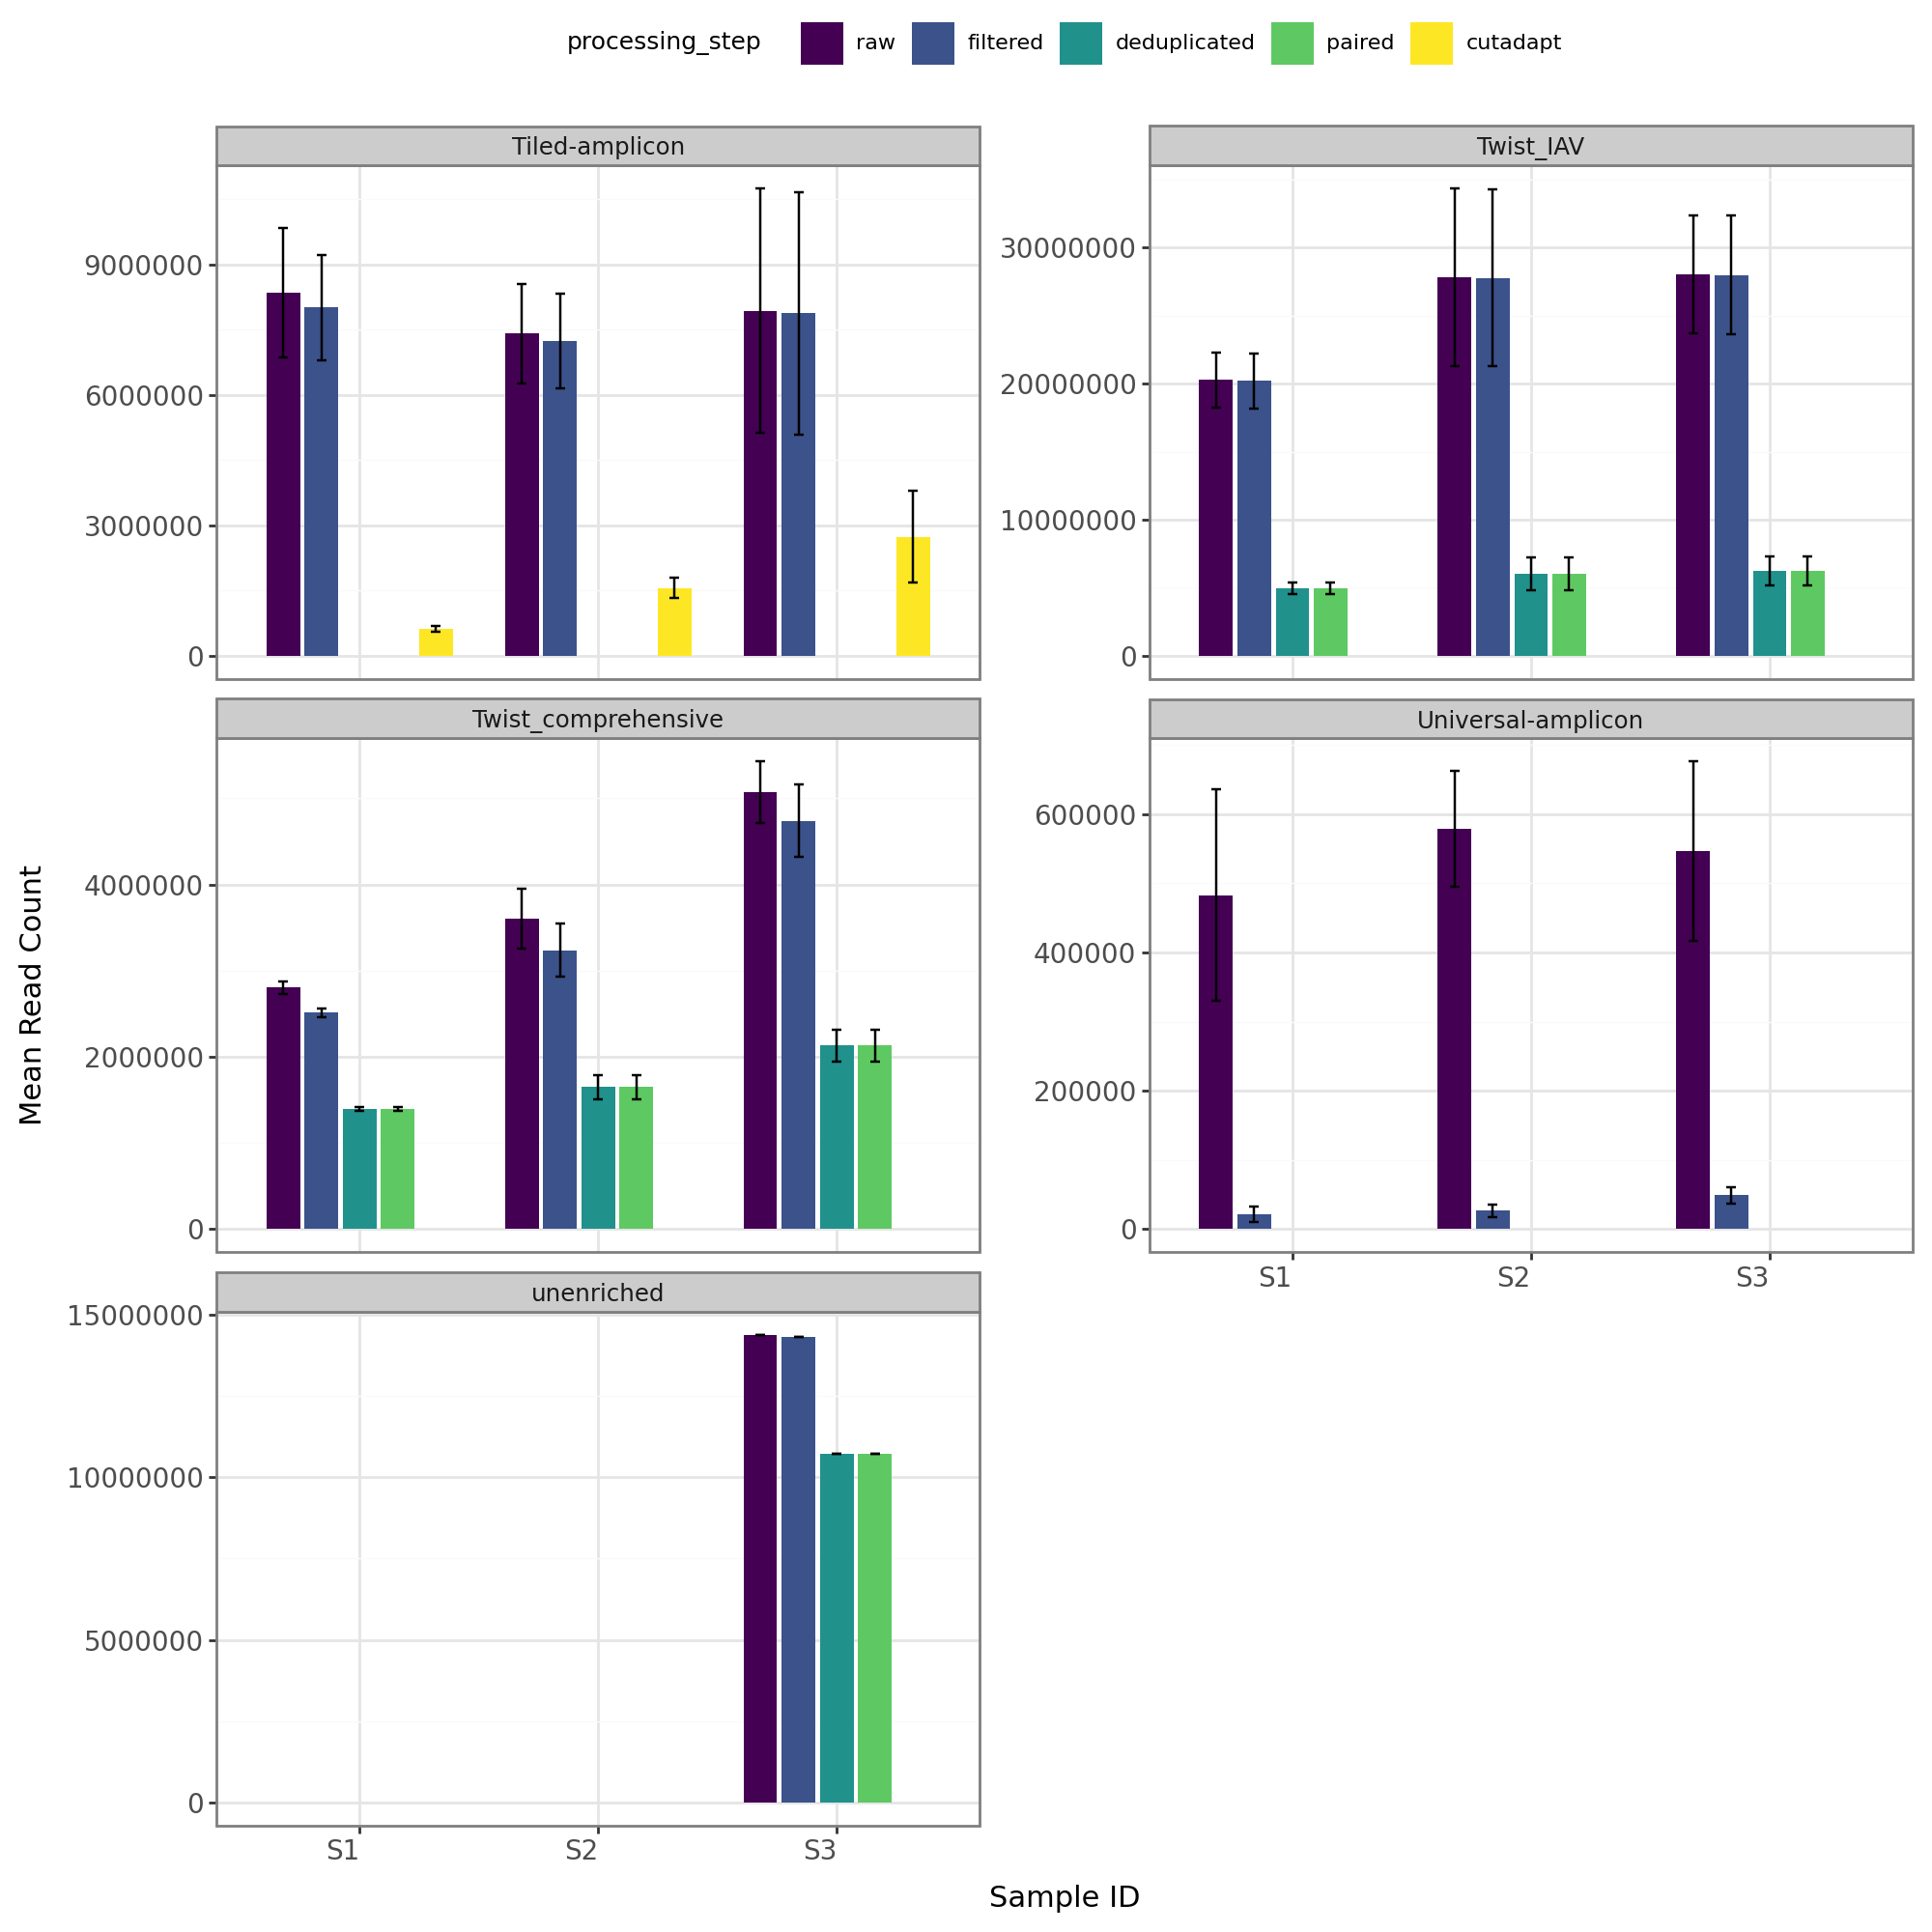

In [ ]:
from plotnine import *

# Add ymin and ymax for error bars
summary_stats['ymin'] = summary_stats['mean'] - summary_stats['std']
summary_stats['ymax'] = summary_stats['mean'] + summary_stats['std']

# Define dodge position to reuse it in both geoms
dodge = position_dodge(width=0.8)

# Plot
p = (
    ggplot(summary_stats, aes(x='sample_id', y='mean', fill='processing_step')) +
    geom_bar(stat='identity', position=dodge, width=0.7) +
    geom_errorbar(aes(ymin='ymin', ymax='ymax'), position=dodge, width=0.2) +
    facet_wrap('~sequencing_method', scales='free_y', ncol=2) +
    labs(x='Sample ID', y='Mean Read Count') +
    theme_bw() +
    theme(
        axis_text_x=element_text(size=10,  hjust=1),
        axis_text_y=element_text(size=10),
        legend_position='top',
        legend_direction='horizontal',
        legend_title=element_text(size=9),
        legend_text=element_text(size=8),
        figure_size=(10, 10)
    )
)


display(p)


/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_bar : Removed 430 rows containing missing values.


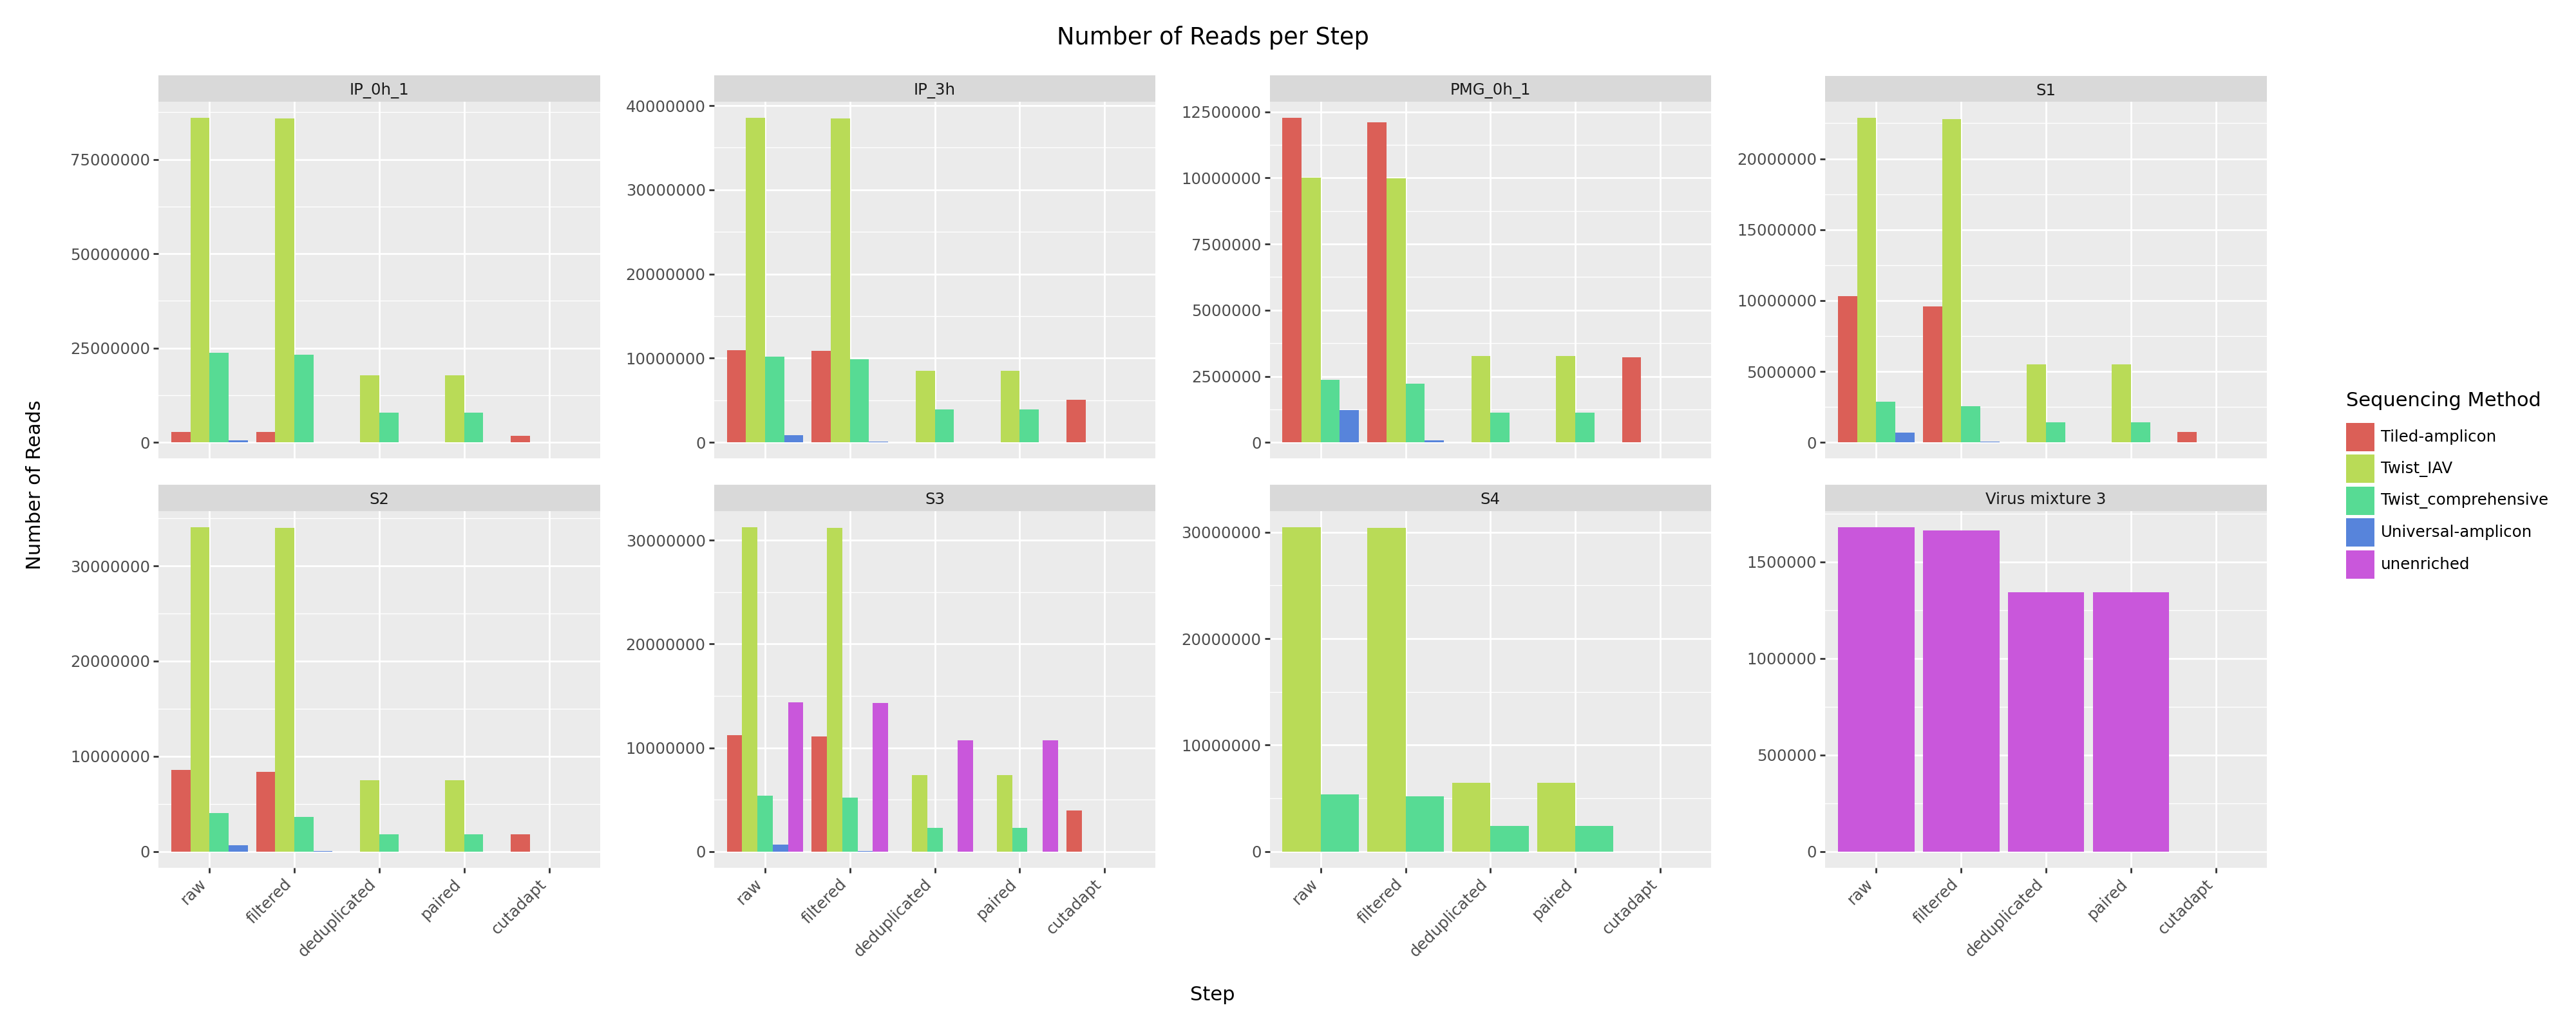

In [ ]:
# Define the order of steps
step_order = ['raw','filtered' ,'deduplicated', 'paired' , 'cutadapt']  # Adjust according to your actual steps

# Update the 'step' column in merged_df to be a categorical type with the desired order
reads_long_df['processing_step'] = pd.Categorical(reads_long_df['processing_step'], categories=step_order, ordered=True)

# Create the plot
(
    ggplot(reads_long_df, aes(x='processing_step', y='read_count', fill='sequencing_method'))
    + geom_bar(stat='identity', position='dodge')  # Bars side by side for each method
    + facet_wrap('~sample_id', scales='free_y',ncol=4)  # Free y-axis scales for each facet
    + labs(title='Number of Reads per Step', x='Step', y='Number of Reads', fill='Sequencing Method')
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(20, 8)  # Set the figure size (width, height)
    )
)


# Coverage Breadth data
- Compiling coverage breadth and mean depth across IAV spike-in reference genomes from samtools coverage
- Using mapping of deduplicated reads against trimmed reference sequences
- allowing only reads > 75 bp (need to confirm this)

In [ ]:
cov_df = []
for f in glob('/content/drive/My Drive/UC Berkeley/IAV_seq_results/Twist_IAV/new/*_coverage_breadth.txt'):
    base = os.path.basename(f).split('.')[0]
    library_id = re.match(r'([\d\w]+)_S.*', base).groups()[0]
    cov = pd.read_csv(f, sep='\t')
    cov['library_id'] = library_id
    cov_df.append(cov)

# Concatenate all coverage dataframes into one
cov_df = pd.concat(cov_df)

# Data cleanup
cov_df = cov_df.rename(columns={'#rname': 'accession'})
cov_df["method"] = "Twist_IAV"

# Rename library_id for consistency
replacement_dict = {
    'DM_IAV_1E2_1': "1", 'DM_IAV_1E2_2': "2", 'DM_IAV_1E2_3': '3',
    'DM_IAV_1E3_1': '4', 'DM_IAV_1E3_2': '5',
    'DM_IAV_1E4_3': '9', 'DM_IAV_1E4_gBlock': '19',
    'Found_Index1': '8', 'Found_Index2': "7", 'Found_Index3': "6",
    'IP_IAV_0': '49', 'IP_IAV_1': '50', 'IP_IAV_2': '51', 'IP_IAV_3': '52',
    'PMG_IAV_0': '53', 'PMG_IAV_1': '54', 'PMG_IAV_3': '56',
    '21_unenriched_1E4': "21", 'M3_stock': "M3"
}
cov_df['library_id'] = cov_df['library_id'].replace(replacement_dict)

# Update method for unenriched samples
cov_df.loc[cov_df['library_id'].isin(["21", "M3"]), 'method'] = 'unenriched'

# Remove samples that should be excluded
cov_df = cov_df[~cov_df['library_id'].isin(['DM_IAV_1E3_3', 'DM_IAV_1E4_1', 'DM_IAV_1E4_2', 'Found_Index4'])]

# Merge with virus strain metadata
cov_df = cov_df.merge(strains_df, how='left', on='accession')
print(cov_df["library_id"].unique())
print(cov_df["library_id"].nunique())
print(cov_df['accession'].unique())
cov_df.head()

['21' '1' '3' '2' '4' '5' '9' '8' '7' '6' '49' '50' '52' '51' 'M3' '53'
 '54' '56']
18
['CY113261.1' 'CY113733.1' 'CY113734.1' 'EF467824.1' 'JF915185.1'
 'EF467823.1' 'JF915187.1' 'CY113737.1' 'EF467820.1' 'JF915188.1'
 'CY113739.1' 'JF915189.1' 'EF467818.1' 'JF915190.1' 'JF915184.1'
 'OR051630.1' 'CY113735.1' 'JF915186.1' 'OR051629.1' 'CY113736.1'
 'EF467822.1' 'EF467817.1' 'JF915191.1' 'CY113738.1' 'EF467819.1'
 'CY113740.1']


accession  startpos  endpos  numreads  covbases  coverage  meandepth  \
0  CY113261.1         1    1684         2       310   18.4086   0.357482   
1  CY113733.1         1    1684         4       364   21.6152   0.432304   
2  CY113734.1         1     982         2       124   12.6273   0.252546   
3  EF467824.1         1     982         2       178   18.1263   0.362525   
4  JF915185.1         1     982         4       397   40.4277   0.932790   

   meanbaseq  meanmapq library_id      method strain segment  segment_number  
0       32.9      27.0         21  unenriched   H3N1      HA               4  
1       33.7      25.5         21  unenriched   H3N2      HA               4  
2       33.1      34.0         21  unenriched   H3N2      MP               7  
3       33.5      14.0         21  unenriched   H3N1      MP               7  
4       33.1      37.5         21  unenriched   H1N1      MP               7

In [ ]:
cov_nano = []
for f in glob('/content/drive/My Drive/UC Berkeley/IAV_seq_results/nanopore/nanopore_coverage/*_coverage_breadth.txt'):
    base = os.path.basename(f).split('.')[0]
    library_id = re.match(r'UCB_IAV_([\d\w]+)_S*', base).groups()[0]
    cov = pd.read_csv(f, sep='\t')
    cov['library_id'] = library_id
    cov_nano.append(cov)
cov_nano = pd.concat(cov_nano)
cov_nano = cov_nano.rename(columns={'#rname':'accession'})
cov_nano["method"]="Universal-amplicon"
cov_nano=cov_nano[~cov_nano['library_id'].isin(["NTC"])]
cov_nano = cov_nano.merge(strains_df, how='left', on='accession')
print(cov_nano["library_id"].unique())
print(cov_nano["library_id"].nunique())
print(cov_nano['accession'].unique())
cov_nano.head()

['31' '32' '33' '34' '35' '36' '37' '38' '39' '81' '82' '83' '84' '85'
 '86' '87' '88']
17
['CY113733.1' 'CY113734.1' 'CY113735.1' 'CY113736.1' 'CY113737.1'
 'CY113738.1' 'JF915189.1' 'CY113740.1' 'JF915190.1' 'CY113261.1'
 'JF915184.1' 'OR051630.1' 'EF467824.1' 'JF915185.1' 'EF467823.1'
 'JF915186.1' 'OR051629.1' 'EF467822.1' 'JF915187.1' 'EF467817.1'
 'JF915191.1' 'EF467820.1' 'JF915188.1' 'CY113739.1' 'EF467819.1'
 'EF467818.1']


accession  startpos  endpos  numreads  covbases  coverage  meandepth  \
0  CY113733.1         1    1684         1      1653   98.1591   0.981591   
1  CY113734.1         1     982         7       982  100.0000   6.190430   
2  CY113735.1         1    1417         1      1241   87.5794   0.875794   
3  CY113736.1         1    1497         1       343   22.9125   0.229125   
4  CY113737.1         1     838         3       838  100.0000   2.170640   

   meanbaseq  meanmapq library_id              method strain segment  \
0       26.8      60.0         31  Universal-amplicon   H3N2      HA   
1       26.9      60.0         31  Universal-amplicon   H3N2      MP   
2       25.8      60.0         31  Universal-amplicon   H3N2      NA   
3       28.4      60.0         31  Universal-amplicon   H3N2      NP   
4       29.5      60.0         31  Universal-amplicon   H3N2      NS   

   segment_number  
0               4  
1               7  
2               6  
3               5  
4               8

In [ ]:
cov_comp = []
for f in glob('/content/drive/My Drive/UC Berkeley/IAV_seq_results/Twist_comp/new/*_coverage_breadth.txt'):
    base = os.path.basename(f).split('.')[0]
    library_id = re.match(r'UCB_WW_Twist_([\d\w]+)_S.*', base).groups()[0]
    cov = pd.read_csv(f, sep='\t')
    cov['library_id'] = library_id
    cov_comp.append(cov)
cov_comp = pd.concat(cov_comp)
cov_comp = cov_comp.rename(columns={'#rname':'accession'})
cov_comp["method"]="Twist_comprehensive"
cov_comp = cov_comp.merge(strains_df, how='left', on='accession')

print(cov_comp["library_id"].unique())
print(cov_comp["library_id"].nunique())
print(cov_comp['accession'].unique())
cov_comp.head()

['10' '11' '12' '13' '14' '15' '16' '17' '20' '18' '57' '58' '59' '60'
 '61' '63' '62' '64' 'NTC']
19
['CY113261.1' 'CY113733.1' 'JF915184.1' 'OR051630.1' 'CY113734.1'
 'EF467824.1' 'JF915185.1' 'CY113735.1' 'EF467823.1' 'JF915186.1'
 'OR051629.1' 'CY113736.1' 'EF467822.1' 'JF915187.1' 'CY113737.1'
 'EF467817.1' 'JF915191.1' 'CY113738.1' 'EF467820.1' 'JF915188.1'
 'CY113739.1' 'EF467819.1' 'JF915189.1' 'CY113740.1' 'EF467818.1'
 'JF915190.1']


accession  startpos  endpos  numreads  covbases  coverage  meandepth  \
0  CY113261.1         1    1684       830      1559   92.5772   67.54390   
1  CY113733.1         1    1684       893      1634   97.0309   75.23220   
2  JF915184.1         1    1701       345       990   58.2011   27.85420   
3  OR051630.1         1    1695        75       965   56.9322    6.65841   
4  CY113734.1         1     982       566       784   79.8371   71.33910   

   meanbaseq  meanmapq library_id               method strain segment  \
0       32.7      24.3         10  Twist_comprehensive   H3N1      HA   
1       32.5      24.8         10  Twist_comprehensive   H3N2      HA   
2       32.5      42.0         10  Twist_comprehensive   H1N1      HA   
3       32.4      42.0         10  Twist_comprehensive   H5N1      HA   
4       32.9      21.4         10  Twist_comprehensive   H3N2      MP   

   segment_number  
0               4  
1               4  
2               4  
3               4  
4               7

In [ ]:
cov_tiled = []
for f in glob('/content/drive/My Drive/UC Berkeley/IAV_seq_results/Tiled_amplicon/coverage/*_coverage_breadth.txt'):
    base = os.path.basename(f).split('.')[0]
    library_id = re.match(r'([\d\w]+)_(?:DM|PMG|IP)', base).groups()[0]
    cov = pd.read_csv(f, sep='\t')
    cov['library_id'] = library_id
    cov_tiled.append(cov)
cov_tiled = pd.concat(cov_tiled)
cov_tiled = cov_tiled.rename(columns={'#rname':'accession'})

cov_tiled["method"]="Tiled-amplicon"
cov_tiled = cov_tiled.merge(strains_df, how='left', on='accession')
print(cov_tiled['segment'].unique())
print(cov_tiled["library_id"].unique())
print(cov_tiled["library_id"].nunique())

['HA' 'MP' 'NA' 'NP' 'NS' 'PA' 'PB1' 'PB2']
['22' '23' '24' '25' '26' '27' '28' '29' '30' '65' '66' '67' '68' '69'
 '70' '71' '72']
17


In [ ]:
Final_cov_breadth=pd.concat([cov_df, cov_comp, cov_tiled,cov_nano])
Final_cov_breadth.to_csv("/content/drive/My Drive/UC Berkeley/IAV_seq_results/coverage_breadth.csv")
print(Final_cov_breadth["library_id"].unique())
print(Final_cov_breadth["library_id"].nunique())
print(Final_cov_breadth["method"].unique())
Final_cov_breadth.head()

['21' '1' '3' '2' '4' '5' '9' '8' '7' '6' '49' '50' '52' '51' 'M3' '53'
 '54' '56' '10' '11' '12' '13' '14' '15' '16' '17' '20' '18' '57' '58'
 '59' '60' '61' '63' '62' '64' 'NTC' '22' '23' '24' '25' '26' '27' '28'
 '29' '30' '65' '66' '67' '68' '69' '70' '71' '72' '31' '32' '33' '34'
 '35' '36' '37' '38' '39' '81' '82' '83' '84' '85' '86' '87' '88']
71
['unenriched' 'Twist_IAV' 'Twist_comprehensive' 'Tiled-amplicon'
 'Universal-amplicon']


accession  startpos  endpos  numreads  covbases  coverage  meandepth  \
0  CY113261.1         1    1684         2       310   18.4086   0.357482   
1  CY113733.1         1    1684         4       364   21.6152   0.432304   
2  CY113734.1         1     982         2       124   12.6273   0.252546   
3  EF467824.1         1     982         2       178   18.1263   0.362525   
4  JF915185.1         1     982         4       397   40.4277   0.932790   

   meanbaseq  meanmapq library_id      method strain segment  segment_number  
0       32.9      27.0         21  unenriched   H3N1      HA               4  
1       33.7      25.5         21  unenriched   H3N2      HA               4  
2       33.1      34.0         21  unenriched   H3N2      MP               7  
3       33.5      14.0         21  unenriched   H3N1      MP               7  
4       33.1      37.5         21  unenriched   H1N1      MP               7

In [ ]:
Final_agg=Final_cov_breadth.groupby(['library_id', 'segment','strain','method']).aggregate(coverage=('coverage','mean'),total_len=('endpos', 'sum'), covbases=('covbases', 'sum'),
                                                                mean_depth=('meandepth', 'mean'), mapped_reads=('numreads', 'sum')).reset_index()
Final_agg.rename(columns={'method': 'sequencing_method'}, inplace=True)
check=Final_cov_breadth[Final_cov_breadth['method']=="Twist_comprehensive"]
check.head()

accession  startpos  endpos  numreads  covbases  coverage  meandepth  \
0  CY113261.1         1    1684       830      1559   92.5772   67.54390   
1  CY113733.1         1    1684       893      1634   97.0309   75.23220   
2  JF915184.1         1    1701       345       990   58.2011   27.85420   
3  OR051630.1         1    1695        75       965   56.9322    6.65841   
4  CY113734.1         1     982       566       784   79.8371   71.33910   

   meanbaseq  meanmapq library_id               method strain segment  \
0       32.7      24.3         10  Twist_comprehensive   H3N1      HA   
1       32.5      24.8         10  Twist_comprehensive   H3N2      HA   
2       32.5      42.0         10  Twist_comprehensive   H1N1      HA   
3       32.4      42.0         10  Twist_comprehensive   H5N1      HA   
4       32.9      21.4         10  Twist_comprehensive   H3N2      MP   

   segment_number  
0               4  
1               4  
2               4  
3               4  
4               7

In [ ]:
# total_len is the segment length, while covbases is the covered bases, covbases/total_len*100=coverage
Twist = Final_agg[~(Final_agg["sequencing_method"] == "Tiled-amplicon") ]
Tiled=Final_agg[Final_agg["sequencing_method"]=="Tiled-amplicon"]
# Update the results to only include HA results for tiled-amplicon
Tiled_HA=Tiled[Tiled["segment"]=="HA"]
cov_agg_final=pd.concat([Tiled_HA,Twist])
print(cov_agg_final['library_id'].unique())
print(cov_agg_final['library_id'].nunique())
print(Twist['sequencing_method'].unique())
# total 55 samples
print(cov_agg_final['strain'].unique())
cov_agg_final.to_csv("/content/drive/My Drive/UC Berkeley/IAV_seq_results/summary_coverage_breadth.csv")
cov_agg_final.head()

['22' '23' '24' '25' '26' '27' '28' '29' '30' '65' '66' '67' '68' '69'
 '70' '71' '72' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '2' '20'
 '21' '3' '31' '32' '33' '34' '35' '36' '37' '38' '39' '4' '49' '5' '50'
 '51' '52' '53' '54' '56' '57' '58' '59' '6' '60' '61' '62' '63' '64' '7'
 '8' '81' '82' '83' '84' '85' '86' '87' '88' '9' 'M3' 'NTC']
71
['Twist_IAV' 'Twist_comprehensive' 'unenriched' 'Universal-amplicon']
['H1N1' 'H3N1' 'H3N2' 'H5N1']


library_id segment strain sequencing_method  coverage  total_len  \
338         22      HA   H1N1    Tiled-amplicon   87.3604       1701   
339         22      HA   H3N1    Tiled-amplicon   84.5012       1684   
340         22      HA   H3N2    Tiled-amplicon   84.5012       1684   
341         22      HA   H5N1    Tiled-amplicon   98.2301       1695   
364         23      HA   H1N1    Tiled-amplicon   87.3604       1701   

     covbases  mean_depth  mapped_reads  
338      1486     964.279          5454  
339      1423   22731.100        127195  
340      1423   12291.500         68793  
341      1665    1799.130         10132  
364      1486     601.942          3404

# **Coverage depth**

In [ ]:
depth_comp = []
column_names = ['accession', 'POSITION', 'COVERAGE']
# Loop through each file in the specified directory
for file in glob('/content/drive/My Drive/UC Berkeley/IAV_seq_results/Twist_comp/new/*_coverage_depth.txt'):
    # Extract the base name of the file and isolate the sample name
    base = os.path.basename(file).split('.')[0]

    # Check if the file is not empty
    if os.path.getsize(file) > 0:
        # Read the file into a DataFrame
        df = pd.read_csv(file, sep='\t', header=None, names=column_names)

        # Extract the library_id from the file name using regex
        df['library_id'] = re.match(r'UCB_WW_Twist_([\d\w]+)_S.*', base).groups()[0]

        # Append the DataFrame to the list
        depth_comp.append(df)
    else:
        print(f"Skipping empty file: {file}")

depth_comp_df = pd.concat(depth_comp, ignore_index=True)
# Add a column to specify the method used
depth_comp_df["method"] = "Twist_comprehensive"

depth_comp_df = depth_comp_df.merge(strains_df, how='left', on='accession')
depth_comp_df=depth_comp_df.merge(samples_libraries_df,how="left",on=['library_id','strain'])
print(depth_comp_df["library_id"].unique())
print(depth_comp_df["library_id"].nunique())
print(depth_comp_df['accession'].unique())
print(depth_comp_df['accession'].nunique())
#print(depth_comp_df['segment'].unique())
#print(depth_comp_df['COVERAGE'].nunique())
depth_comp_df.shape
depth_comp_df.head()

Skipping empty file: /content/drive/My Drive/UC Berkeley/IAV_seq_results/Twist_comp/new/UCB_WW_Twist_NTC_S23_coverage_depth.txt
['10' '12' '11' '13' '14' '15' '17' '16' '18' '20' '57' '58' '59' '61'
 '60' '62' '64' '63']
18
['CY113261.1' 'CY113733.1' 'JF915184.1' 'OR051630.1' 'CY113734.1'
 'EF467824.1' 'JF915185.1' 'CY113735.1' 'EF467823.1' 'JF915186.1'
 'OR051629.1' 'CY113736.1' 'EF467822.1' 'JF915187.1' 'CY113737.1'
 'EF467817.1' 'JF915191.1' 'CY113738.1' 'EF467820.1' 'JF915188.1'
 'CY113739.1' 'EF467819.1' 'JF915189.1' 'CY113740.1' 'EF467818.1'
 'JF915190.1']
26


accession  POSITION  COVERAGE library_id               method strain  \
0  CY113261.1         1         0         10  Twist_comprehensive   H3N1   
1  CY113261.1         2         0         10  Twist_comprehensive   H3N1   
2  CY113261.1         3         0         10  Twist_comprehensive   H3N1   
3  CY113261.1         4         0         10  Twist_comprehensive   H3N1   
4  CY113261.1         5         0         10  Twist_comprehensive   H3N1   

  segment  segment_number sample_name sample_id WW_method  \
0      HA               4       S1_10        S1        DM   
1      HA               4       S1_10        S1        DM   
2      HA               4       S1_10        S1        DM   
3      HA               4       S1_10        S1        DM   
4      HA               4       S1_10        S1        DM   

   dPCR_postFreeze_thaw_gc_ul    sequencing_method  
0                       2.836  Twist_comprehensive  
1                       2.836  Twist_comprehensive  
2                       2.836  Twist_comprehensive  
3                       2.836  Twist_comprehensive  
4                       2.836  Twist_comprehensive

In [ ]:
depth_nano = []
column_names = ['accession', 'POSITION', 'COVERAGE']
# Loop through each file in the specified directory
for file in glob('/content/drive/My Drive/UC Berkeley/IAV_seq_results/nanopore/nanopore_coverage/*_coverage_depth.txt'):
    # Extract the base name of the file and isolate the sample name
    base = os.path.basename(file).split('.')[0]

    # Check if the file is not empty
    if os.path.getsize(file) > 0:
        # Read the file into a DataFrame
        df = pd.read_csv(file, sep='\t', header=None, names=column_names)

        # Extract the library_id from the file name using regex
        df['library_id'] = re.match(r'UCB_IAV_([\d\w]+)_S*', base).groups()[0]

        # Append the DataFrame to the list
        depth_nano.append(df)
    else:
        print(f"Skipping empty file: {file}")

depth_nano = pd.concat(depth_nano, ignore_index=True)
# Add a column to specify the method used
depth_nano["method"] = "Universal-amplicon"

depth_nano = depth_nano.merge(strains_df, how='left', on='accession')
depth_nano=depth_nano.merge(samples_libraries_df,how="left",on=['library_id','strain'])
print(depth_nano["library_id"].unique())
print(depth_nano["library_id"].nunique())
print(depth_nano['accession'].unique())
#print(depth_comp_df['accession'].nunique())
print(depth_nano['segment'].unique())
#print(depth_comp_df['COVERAGE'].nunique())
depth_nano.head()

Skipping empty file: /content/drive/My Drive/UC Berkeley/IAV_seq_results/nanopore/nanopore_coverage/UCB_IAV_NTC_SQK-NBD114-24_barcode18_coverage_depth.txt
['31' '32' '33' '34' '35' '36' '37' '38' '39' '81' '82' '83' '84' '85'
 '86' '87' '88']
17
['CY113733.1' 'CY113734.1' 'CY113735.1' 'CY113736.1' 'CY113737.1'
 'CY113738.1' 'JF915189.1' 'CY113740.1' 'JF915190.1' 'EF467824.1'
 'JF915185.1' 'EF467817.1' 'JF915191.1' 'EF467820.1' 'EF467818.1'
 'JF915186.1' 'CY113739.1' 'EF467819.1' 'JF915184.1' 'EF467823.1'
 'EF467822.1' 'JF915188.1' 'JF915187.1' 'CY113261.1']
['HA' 'MP' 'NA' 'NP' 'NS' 'PA' 'PB1' 'PB2']


accession  POSITION  COVERAGE library_id              method strain  \
0  CY113733.1         1         1         31  Universal-amplicon   H3N2   
1  CY113733.1         2         1         31  Universal-amplicon   H3N2   
2  CY113733.1         3         1         31  Universal-amplicon   H3N2   
3  CY113733.1         4         1         31  Universal-amplicon   H3N2   
4  CY113733.1         5         1         31  Universal-amplicon   H3N2   

  segment  segment_number sample_name sample_id WW_method  \
0      HA               4       S1_31        S1        DM   
1      HA               4       S1_31        S1        DM   
2      HA               4       S1_31        S1        DM   
3      HA               4       S1_31        S1        DM   
4      HA               4       S1_31        S1        DM   

   dPCR_postFreeze_thaw_gc_ul   sequencing_method  
0                       1.488  Universal-amplicon  
1                       1.488  Universal-amplicon  
2                       1.488  Universal-amplicon  
3                       1.488  Universal-amplicon  
4                       1.488  Universal-amplicon

In [ ]:
column_names = ['accession', 'POSITION', 'COVERAGE']
depth_IAV = []
# Loop through each file in Twist_IAV directory
for file in glob('/content/drive/My Drive/UC Berkeley/IAV_seq_results/Twist_IAV/new/*_coverage_depth.txt'):
    base = os.path.basename(file).split('.')[0]
    library_id = re.match(r'([\d\w]+)_S.*', base).groups()[0]
    cov = pd.read_csv(file, sep='\t', header=None, names=column_names)
    cov['library_id'] = library_id
     # Retain only the required columns
    depth_IAV.append(cov)
# Combine all DataFrames into a single DataFrame
depth_IAV = pd.concat(depth_IAV, ignore_index=True)
# Add 'method' column
depth_IAV["method"] = "Twist_IAV"
depth_IAV = depth_IAV.merge(strains_df, how='left', on='accession')
replacement_dict = {
    'DM_IAV_1E2_1': "1",'DM_IAV_1E2_2': "2",'DM_IAV_1E2_3': '3','DM_IAV_1E3_1': '4','DM_IAV_1E3_2': '5','DM_IAV_1E4_3': '9','DM_IAV_1E4_gBlock': '19','Found_Index1': '8',
    'Found_Index2': "7",'Found_Index3': "6",'IP_IAV_0': '49','IP_IAV_1': '50','IP_IAV_2': '51','IP_IAV_3': '52','PMG_IAV_0': '53','PMG_IAV_1': '54','PMG_IAV_3': '56','21_unenriched_1E4' :"21",'M3_stock':"M3"}
depth_IAV['library_id'] = depth_IAV['library_id'].replace(replacement_dict)
depth_IAV.loc[depth_IAV['library_id'].isin(["21", 'M3']), 'method'] = 'unenriched'
depth_IAV = depth_IAV[~depth_IAV['library_id'].isin(['DM_IAV_1E3_3', 'DM_IAV_1E4_1', 'DM_IAV_1E4_2', 'Found_Index4'])]
depth_IAV = depth_IAV[~depth_IAV['accession'].isin(['CY113261.1/1-1684', 'CY113733.1/1-1684' ,'JF915184.1/1-1701'])]

# Display the first few rows of the combined DataFrame
depth_IAV=depth_IAV.merge(samples_libraries_df,how="left",on=['library_id','strain'])
print(depth_IAV['library_id'].unique())
print(depth_IAV['library_id'].nunique())
print(depth_IAV['accession'].unique())
print(depth_IAV['accession'].nunique())
print(depth_IAV['strain'].unique())
print(depth_IAV['segment'].unique())
depth_IAV.head()

['21' '1' '2' '3' '4' '5' '9' '8' '7' '6' '50' '49' '51' 'M3' '52' '53'
 '54' '56']
18
['CY113261.1' 'CY113733.1' 'CY113734.1' 'EF467824.1' 'JF915185.1'
 'EF467823.1' 'JF915187.1' 'CY113737.1' 'EF467820.1' 'JF915188.1'
 'CY113739.1' 'JF915189.1' 'EF467818.1' 'JF915190.1' 'JF915184.1'
 'OR051630.1' 'CY113735.1' 'JF915186.1' 'OR051629.1' 'CY113736.1'
 'EF467822.1' 'EF467817.1' 'JF915191.1' 'CY113738.1' 'EF467819.1'
 'CY113740.1']
26
['H3N1' 'H3N2' 'H1N1' 'H5N1']
['HA' 'MP' 'NA' 'NP' 'NS' 'PA' 'PB1' 'PB2']


accession POSITION COVERAGE library_id      method strain segment  \
0  CY113261.1        1        0         21  unenriched   H3N1      HA   
1  CY113261.1        2        0         21  unenriched   H3N1      HA   
2  CY113261.1        3        0         21  unenriched   H3N1      HA   
3  CY113261.1        4        0         21  unenriched   H3N1      HA   
4  CY113261.1        5        0         21  unenriched   H3N1      HA   

   segment_number sample_name sample_id WW_method  dPCR_postFreeze_thaw_gc_ul  \
0               4       S3_21        S3        DM                      33.352   
1               4       S3_21        S3        DM                      33.352   
2               4       S3_21        S3        DM                      33.352   
3               4       S3_21        S3        DM                      33.352   
4               4       S3_21        S3        DM                      33.352   

  sequencing_method  
0        unenriched  
1        unenriched  
2        unenriched  
3        unenriched  
4        unenriched

In [ ]:
summary = (
    depth_IAV.groupby(['strain', 'segment','sample_id','method'], observed=True)
    .agg(
        total_rows=('POSITION', 'count'),
        unique_positions=('POSITION', 'nunique')
    )
    .reset_index()
    .sort_values(['strain', 'segment'])
)

# Output result
summary

strain segment sample_id     method  total_rows  unique_positions
0     H1N1      HA   IP_0h_1  Twist_IAV        1701              1701
1     H1N1      HA   IP_3h_1  Twist_IAV        1701              1701
2     H1N1      HA   IP_3h_2  Twist_IAV        1701              1701
3     H1N1      HA   IP_3h_3  Twist_IAV        1701              1701
4     H1N1      HA  PMG_0h_1  Twist_IAV        1701              1701
..     ...     ...       ...        ...         ...               ...
255   H5N1      HA        S2  Twist_IAV        5085              1695
256   H5N1      HA        S3  Twist_IAV        5085              1695
257   H5N1      NA        S1  Twist_IAV        4230              1410
258   H5N1      NA        S2  Twist_IAV        4230              1410
259   H5N1      NA        S3  Twist_IAV        4230              1410

[260 rows x 6 columns]

In [ ]:
depth_tiled = []
column_names = ['accession', 'POSITION', 'COVERAGE']
for f in glob('/content/drive/My Drive/UC Berkeley/IAV_seq_results/Tiled_amplicon/coverage/*_coverage_depth.txt'):
    base = os.path.basename(f).split('.')[0]
    library_id = re.match(r'([\d\w]+)_(?:DM|PMG|IP)', base).groups()[0]
    cov_tiled = pd.read_csv(f, sep='\t',  names=column_names)
    cov_tiled['library_id'] = library_id
    depth_tiled.append(cov_tiled)
depth_tiled = pd.concat(depth_tiled)
depth_tiled["method"]="Tiled-amplicon"
depth_tiled = depth_tiled.merge(strains_df, how='left', on='accession')
# Display the first few rows of the combined DataFrame
depth_tiled=depth_tiled.merge(samples_libraries_df,how="left",on=['library_id','strain'])
print(depth_tiled['library_id'].unique())
print(depth_tiled['library_id'].nunique())
print(depth_tiled['accession'].unique())
print(depth_tiled['accession'].nunique())
print(depth_tiled['COVERAGE'].nunique())
depth_tiled.head()

['22' '23' '24' '25' '26' '27' '28' '29' '30' '65' '66' '67' '68' '69'
 '70' '71' '72']
17
['CY113261.1' 'CY113733.1' 'JF915184.1' 'OR051630.1' 'CY113739.1'
 'JF915189.1' 'CY113734.1' 'CY113735.1' 'CY113736.1' 'CY113738.1'
 'EF467824.1' 'JF915185.1' 'JF915188.1' 'JF915187.1' 'CY113737.1']
15
19071


accession  POSITION  COVERAGE library_id          method strain segment  \
0  CY113261.1         1         0         22  Tiled-amplicon   H3N1      HA   
1  CY113261.1         2         0         22  Tiled-amplicon   H3N1      HA   
2  CY113261.1         3         0         22  Tiled-amplicon   H3N1      HA   
3  CY113261.1         4         0         22  Tiled-amplicon   H3N1      HA   
4  CY113261.1         5         0         22  Tiled-amplicon   H3N1      HA   

   segment_number sample_name sample_id WW_method  dPCR_postFreeze_thaw_gc_ul  \
0               4       S1_22        S1        DM                       2.836   
1               4       S1_22        S1        DM                       2.836   
2               4       S1_22        S1        DM                       2.836   
3               4       S1_22        S1        DM                       2.836   
4               4       S1_22        S1        DM                       2.836   

  sequencing_method  
0    Tiled-amplicon  
1    Tiled-amplicon  
2    Tiled-amplicon  
3    Tiled-amplicon  
4    Tiled-amplicon

In [ ]:
check=depth_tiled.loc[(depth_tiled.strain == 'H3N2')]
print(check['accession'].unique())

['CY113733.1' 'CY113739.1' 'CY113734.1' 'CY113735.1' 'CY113736.1'
 'CY113738.1' 'CY113737.1']


In [ ]:
Final_depth=pd.concat([depth_nano, depth_comp_df, depth_IAV, depth_tiled])
Final_depth.to_csv("/content/drive/My Drive/UC Berkeley/IAV_seq_results/summary_coverage_depth.csv")
print(Final_depth['library_id'].unique())
print(Final_depth['library_id'].nunique())
print(Final_depth['sample_name'].unique())
# Only 71 samples, didn't include NTC
Final_depth.head()

['31' '32' '33' '34' '35' '36' '37' '38' '39' '81' '82' '83' '84' '85'
 '86' '87' '88' '10' '12' '11' '13' '14' '15' '17' '16' '18' '20' '57'
 '58' '59' '61' '60' '62' '64' '63' '21' '1' '2' '3' '4' '5' '9' '8' '7'
 '6' '50' '49' '51' 'M3' '52' '53' '54' '56' '22' '23' '24' '25' '26' '27'
 '28' '29' '30' '65' '66' '67' '68' '69' '70' '71' '72']
70
<StringArray>
[      'S1_31',       'S1_32',       'S1_33',       'S2_34',       'S2_35',
       'S2_36',       'S3_37',       'S3_38',       'S3_39',  'IP_0h_1_81',
  'IP_3h_1_82',  'IP_3h_2_83',  'IP_3h_3_84', 'PMG_0h_1_85', 'PMG_3h_1_86',
 'PMG_3h_2_87', 'PMG_3h_3_88',       'S1_10',       'S1_12',       'S1_11',
       'S2_13',       'S2_14',       'S2_15',       'S3_17',       'S3_16',
       'S3_18',       'S4_20',  'IP_0h_1_57',  'IP_3h_1_58',  'IP_3h_2_59',
 'PMG_0h_1_61',  'IP_3h_3_60', 'PMG_3h_1_62', 'PMG_3h_3_64', 'PMG_3h_2_63',
       'S3_21',        'S1_1',        'S1_2',        'S1_3',        'S2_4',
        'S2_5',        'S3_9

accession POSITION COVERAGE library_id              method strain segment  \
0  CY113733.1        1        1         31  Universal-amplicon   H3N2      HA   
1  CY113733.1        2        1         31  Universal-amplicon   H3N2      HA   
2  CY113733.1        3        1         31  Universal-amplicon   H3N2      HA   
3  CY113733.1        4        1         31  Universal-amplicon   H3N2      HA   
4  CY113733.1        5        1         31  Universal-amplicon   H3N2      HA   

   segment_number sample_name sample_id WW_method  dPCR_postFreeze_thaw_gc_ul  \
0               4       S1_31        S1        DM                       1.488   
1               4       S1_31        S1        DM                       1.488   
2               4       S1_31        S1        DM                       1.488   
3               4       S1_31        S1        DM                       1.488   
4               4       S1_31        S1        DM                       1.488   

    sequencing_method  
0  Universal-amplicon  
1  Universal-amplicon  
2  Universal-amplicon  
3  Universal-amplicon  
4  Universal-amplicon

# ** Coverage depth + *AF*

In [ ]:
AF_comp = []
# Loop through each file in directory
for file in glob('/content/drive/My Drive/UC Berkeley/IAV_seq_results/Twist_comp/coverage/*_ivar_call.txt.tsv'):
    # Extract the sample name from the filename
    base = os.path.basename(file).split('.')[0]

    # Read the file into a DataFrame
    df = pd.read_csv(file, sep='\t')

    # Extract the library_id from the file column
    df['library_id'] = re.match(r'UCB_WW_Twist_([\d\w]+)_S.*', base).groups()[0]

    # Retain only the required columns
    df = df[['REGION', 'POS', 'ALT_FREQ', 'TOTAL_DP', 'library_id']]

    # Append the DataFrame to the list
    AF_comp.append(df)

# Combine all DataFrames into a single DataFrame
AF_comp_df = pd.concat(AF_comp, ignore_index=True)
AF_comp_df["method"]="Twist_comprehensive"
AF_comp_df.rename(columns={'REGION': 'accession'}, inplace=True)
AF_comp_df = AF_comp_df.merge(strains_df, how='left', on='accession')
AF_comp_df=AF_comp_df.merge(samples_libraries_df,how="left",on=['library_id','strain'])
AF_comp_df.head()

<ipython-input-53-1214815210>:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


accession  POS  ALT_FREQ TOTAL_DP library_id               method strain  \
0  CY113261.1  635  0.100000       10         10  Twist_comprehensive   H3N1   
1  CY113261.1  747  0.312500       16         10  Twist_comprehensive   H3N1   
2  CY113261.1  921  0.235294       17         10  Twist_comprehensive   H3N1   
3  CY113261.1  922  0.235294       17         10  Twist_comprehensive   H3N1   
4  CY113261.1  948  0.058824       17         10  Twist_comprehensive   H3N1   

  segment  segment_number sample_name sample_id WW_method  \
0      HA               4       S1_10        S1        DM   
1      HA               4       S1_10        S1        DM   
2      HA               4       S1_10        S1        DM   
3      HA               4       S1_10        S1        DM   
4      HA               4       S1_10        S1        DM   

   dPCR_postFreeze_thaw_gc_ul    sequencing_method  
0                       2.836  Twist_comprehensive  
1                       2.836  Twist_comprehensive  
2                       2.836  Twist_comprehensive  
3                       2.836  Twist_comprehensive  
4                       2.836  Twist_comprehensive

In [ ]:
AF_nano = []
# Loop through each file in directory
for file in glob('/content/drive/My Drive/UC Berkeley/IAV_seq_results/nanopore/nanopore_coverage/*_ivar_call.txt.tsv'):
    # Extract the sample name from the filename
    base = os.path.basename(file).split('.')[0]

    # Read the file into a DataFrame
    df = pd.read_csv(file, sep='\t')

    # Extract the library_id from the file column
    df['library_id'] = re.match(r'UCB_IAV_([\d\w]+)_S*', base).groups()[0]

    # Retain only the required columns
    df = df[['REGION', 'POS', 'ALT_FREQ', 'TOTAL_DP', 'library_id']]

    # Append the DataFrame to the list
    AF_nano.append(df)

# Combine all DataFrames into a single DataFrame
AF_nano = pd.concat(AF_nano, ignore_index=True)
AF_nano["method"]="Universal-amplicon"
AF_nano.rename(columns={'REGION': 'accession'}, inplace=True)
AF_nano = AF_nano.merge(strains_df, how='left', on='accession')
AF_nano=AF_nano.merge(samples_libraries_df,how="left",on=['library_id','strain'])
AF_nano.head()

<ipython-input-54-2549038761>:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


accession POS  ALT_FREQ TOTAL_DP library_id              method strain  \
0  JF915189.1  14  0.046875      128         31  Universal-amplicon   H1N1   
1  JF915189.1  16  0.046875      128         31  Universal-amplicon   H1N1   
2  JF915189.1  18  0.109375      128         31  Universal-amplicon   H1N1   
3  JF915189.1  22  0.148438      128         31  Universal-amplicon   H1N1   
4  JF915189.1  29  0.039062      128         31  Universal-amplicon   H1N1   

  segment  segment_number sample_name sample_id WW_method  \
0     PB1               2       S1_31        S1        DM   
1     PB1               2       S1_31        S1        DM   
2     PB1               2       S1_31        S1        DM   
3     PB1               2       S1_31        S1        DM   
4     PB1               2       S1_31        S1        DM   

   dPCR_postFreeze_thaw_gc_ul   sequencing_method  
0                       5.352  Universal-amplicon  
1                       5.352  Universal-amplicon  
2                       5.352  Universal-amplicon  
3                       5.352  Universal-amplicon  
4                       5.352  Universal-amplicon

In [ ]:
AF_IAV = []
# Loop through each file in Twist_IAV directory
for file in glob('/content/drive/My Drive/UC Berkeley/IAV_seq_results/Twist_IAV/coverage/*_ivar_call.txt.tsv'):
    base = os.path.basename(file).split('.')[0]
    library_id = re.match(r'([\d\w]+)_S.*', base).groups()[0]
    cov = pd.read_csv(file, sep='\t')
    cov['library_id'] = library_id
     # Retain only the required columns
    cov = cov[['REGION', 'POS', 'ALT_FREQ', 'TOTAL_DP', 'library_id']]  # Fixed indentation and reassignment
    AF_IAV.append(cov)
# Combine all DataFrames into a single DataFrame
AF_IAV = pd.concat(AF_IAV, ignore_index=True)
# Add 'method' column
AF_IAV["method"] = "Twist_IAV"

AF_IAV.rename(columns={'REGION': 'accession'}, inplace=True)
AF_IAV = AF_IAV.merge(strains_df, how='left', on='accession')
replacement_dict = {
    'DM_IAV_1E2_1': "1",'DM_IAV_1E2_2': "2",'DM_IAV_1E2_3': '3','DM_IAV_1E3_1': '4','DM_IAV_1E3_2': '5','DM_IAV_1E4_3': '9','DM_IAV_1E4_gBlock': '19','Found_Index1': '8',
    'Found_Index2': "7",'Found_Index3': "6",'IP_IAV_0': '49','IP_IAV_1': '50','IP_IAV_2': '51','IP_IAV_3': '52','PMG_IAV_0': '53','PMG_IAV_1': '54','PMG_IAV_3': '56','21_unenriched_1E4' :"21",'M3_stock':"M3"}
AF_IAV['library_id'] = AF_IAV['library_id'].replace(replacement_dict)
AF_IAV.loc[AF_IAV['library_id'].isin(["21", 'M3']), 'method'] = 'unenriched'
AF_IAV = AF_IAV[~AF_IAV['library_id'].isin(['DM_IAV_1E3_3', 'DM_IAV_1E4_1', 'DM_IAV_1E4_2', 'Found_Index4'])]

# Display the first few rows of the combined DataFrame
AF_IAV=AF_IAV.merge(samples_libraries_df,how="left",on=['library_id','strain'])
AF_IAV.head()

<ipython-input-26-b2e90ef61007>:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


accession  POS  ALT_FREQ TOTAL_DP library_id     method strain segment  \
0  CY113261.1  140  0.058824       34         56  Twist_IAV   H3N1      HA   
1  CY113261.1  141  0.058824       17         56  Twist_IAV   H3N1      HA   
2  CY113261.1  184  0.055556       18         56  Twist_IAV   H3N1      HA   
3  CY113261.1  185  0.277778       18         56  Twist_IAV   H3N1      HA   
4  CY113261.1  195  0.055556       18         56  Twist_IAV   H3N1      HA   

   segment_number  sample_name sample_id WW_method  \
0               4  PMG_3h_3_56  PMG_3h_3       PMG   
1               4  PMG_3h_3_56  PMG_3h_3       PMG   
2               4  PMG_3h_3_56  PMG_3h_3       PMG   
3               4  PMG_3h_3_56  PMG_3h_3       PMG   
4               4  PMG_3h_3_56  PMG_3h_3       PMG   

   dPCR_postFreeze_thaw_gc_ul sequencing_method  
0                      158.48         Twist_IAV  
1                      158.48         Twist_IAV  
2                      158.48         Twist_IAV  
3                      158.48         Twist_IAV  
4                      158.48         Twist_IAV

In [ ]:
AF_tiled = []
for f in glob('/content/drive/My Drive/UC Berkeley/IAV_seq_results/Tiled_amplicon/coverage/*_ivar_call.txt.tsv'):
    base = os.path.basename(f).split('.')[0]
    library_id = re.match(r'([\d\w]+)_(?:DM|PMG|IP)', base).groups()[0]
    cov = pd.read_csv(f, sep='\t')
    cov['library_id'] = library_id
    cov = cov[['REGION', 'POS', 'ALT_FREQ', 'TOTAL_DP', 'library_id']]  # Fixed indentation and reassignment
    AF_tiled.append(cov)
AF_tiled = pd.concat(AF_tiled)
AF_tiled.rename(columns={'REGION': 'accession'}, inplace=True)
AF_tiled = AF_tiled.merge(strains_df, how='left', on='accession')

AF_tiled["method"]="Tiled-amplicon"

# Display the first few rows of the combined DataFrame
AF_tiled=AF_tiled.merge(samples_libraries_df,how="left",on=['library_id','strain'])
AF_tiled.head()

accession  POS  ALT_FREQ  TOTAL_DP library_id strain segment  \
0  CY113261.1  255  0.475718     50408         22   H3N1      HA   
1  CY113261.1  261  0.289240     51051         22   H3N1      HA   
2  CY113261.1  412  0.358950     52921         22   H3N1      HA   
3  CY113261.1  651  0.992541     48934         22   H3N1      HA   
4  CY113261.1  660  0.992630     49117         22   H3N1      HA   

   segment_number          method sample_name sample_id WW_method  \
0               4  Tiled-amplicon       S1_22        S1        DM   
1               4  Tiled-amplicon       S1_22        S1        DM   
2               4  Tiled-amplicon       S1_22        S1        DM   
3               4  Tiled-amplicon       S1_22        S1        DM   
4               4  Tiled-amplicon       S1_22        S1        DM   

   dPCR_postFreeze_thaw_gc_ul sequencing_method  
0                       2.836    Tiled-amplicon  
1                       2.836    Tiled-amplicon  
2                       2.836    Tiled-amplicon  
3                       2.836    Tiled-amplicon  
4                       2.836    Tiled-amplicon

In [ ]:
Final_AF=pd.concat([AF_nano, AF_comp_df, AF_IAV, AF_tiled])
Final_AF.to_csv("/content/drive/My Drive/UC Berkeley/IAV_seq_results/summary_coverage_AF.csv")
print(Final_AF['library_id'].unique())
print(Final_AF['library_id'].nunique())
check=Final_AF.loc[(Final_AF.library_id == '21')]
print(check['accession'].unique())
# didn't include NTC, also the ivar file of sample 21 unenriched is empty. (probably the coverage is too low to call variants)

['31' '32' '33' '34' '35' '36' '37' '38' '39' '81' '82' '83' '84' '85'
 '86' '87' '88' '10' '11' '12' '13' '14' '15' '16' '17' '18' '57' '58'
 '59' '60' '61' '62' '63' '64' '20' '56' '54' '53' 'M3' '52' '51' '50'
 '49' '7' '6' '8' '9' '5' '3' '4' '1' '2' '19' '22' '23' '24' '25' '26'
 '27' '28' '29' '30' '65' '66' '67' '68' '69' '70' '71' '72']
70
[]


In [ ]:
Final_AF.head()

accession POS  ALT_FREQ TOTAL_DP library_id              method strain  \
0  JF915189.1  14  0.046875      128         31  Universal-amplicon   H1N1   
1  JF915189.1  16  0.046875      128         31  Universal-amplicon   H1N1   
2  JF915189.1  18  0.109375      128         31  Universal-amplicon   H1N1   
3  JF915189.1  22  0.148438      128         31  Universal-amplicon   H1N1   
4  JF915189.1  29  0.039062      128         31  Universal-amplicon   H1N1   

  segment  segment_number sample_name sample_id WW_method  \
0     PB1               2       S1_31        S1        DM   
1     PB1               2       S1_31        S1        DM   
2     PB1               2       S1_31        S1        DM   
3     PB1               2       S1_31        S1        DM   
4     PB1               2       S1_31        S1        DM   

   dPCR_postFreeze_thaw_gc_ul   sequencing_method  
0                       5.352  Universal-amplicon  
1                       5.352  Universal-amplicon  
2                       5.352  Universal-amplicon  
3                       5.352  Universal-amplicon  
4                       5.352  Universal-amplicon

# Merging all data and calculate RPKM

In [ ]:
merged_final = samples_libraries_df.merge(cov_agg_final, how='left', on=['library_id', 'strain','sequencing_method'])
merged_final=merged_final.merge(reads_sum_wide,how='left',on='library_id')
merged_final=merged_final.merge(Final_depth,how='left',on=['library_id','strain','sequencing_method','segment','sample_name','sample_id','WW_method','dPCR_postFreeze_thaw_gc_ul'])
print(merged_final['library_id'].unique())
print(merged_final['library_id'].nunique())
merged_final.head()

['40' '41' '43' '44' '45' '46' '47' '48' '22' '23' '24' '25' '26' '27'
 '28' '29' '30' '65' '66' '67' '68' '69' '70' '71' '72' '10' '11' '12'
 '13' '14' '15' '16' '17' '18' '20' '57' '58' '59' '60' '61' '62' '63'
 '64' '1' '2' '3' '4' '5' '6' '7' '8' '9' '19' '49' '50' '51' '52' '53'
 '54' '55' '56' '21' 'M3' '31' '32' '33' '34' '35' '36' '37' '38' '39'
 '81' '82' '83' '84' '85' '86' '87' '88']
80


sample_name sample_id library_id WW_method strain  \
0       S1_40        S1         40        DM   H1N1   
1       S1_40        S1         40        DM   H3N1   
2       S1_40        S1         40        DM   H3N2   
3       S1_40        S1         40        DM   H5N1   
4       S1_41        S1         41        DM   H1N1   

   dPCR_postFreeze_thaw_gc_ul  sequencing_method segment  coverage  total_len  \
0                       5.352  Targeted-amplicon     NaN       NaN        NaN   
1                       2.836  Targeted-amplicon     NaN       NaN        NaN   
2                       1.488  Targeted-amplicon     NaN       NaN        NaN   
3                       0.000  Targeted-amplicon     NaN       NaN        NaN   
4                       5.352  Targeted-amplicon     NaN       NaN        NaN   

   ...  cutadapt  deduplicated  filtered  paired  raw  accession  POSITION  \
0  ...       NaN           NaN       NaN     NaN  NaN        NaN       NaN   
1  ...       NaN           NaN       NaN     NaN  NaN        NaN       NaN   
2  ...       NaN           NaN       NaN     NaN  NaN        NaN       NaN   
3  ...       NaN           NaN       NaN     NaN  NaN        NaN       NaN   
4  ...       NaN           NaN       NaN     NaN  NaN        NaN       NaN   

   COVERAGE method segment_number  
0       NaN    NaN            NaN  
1       NaN    NaN            NaN  
2       NaN    NaN            NaN  
3       NaN    NaN            NaN  
4       NaN    NaN            NaN  

[5 rows x 23 columns]

In [ ]:
# This is merged with total reads length instead of total reads number
merged_final_2 = samples_libraries_df.merge(cov_agg_final, how='left', on=['library_id', 'strain','sequencing_method'])
merged_final_2=merged_final_2.merge(reads_sum_wide_2,how='left',on='library_id')
merged_final_2=merged_final_2.merge(Final_depth,how='left',on=['library_id','strain','sequencing_method','segment','sample_name','sample_id','WW_method','dPCR_postFreeze_thaw_gc_ul'])
merged_final_2.head()

sample_name sample_id library_id WW_method strain  \
0       S1_40        S1         40        DM   H1N1   
1       S1_40        S1         40        DM   H3N1   
2       S1_40        S1         40        DM   H3N2   
3       S1_40        S1         40        DM   H5N1   
4       S1_41        S1         41        DM   H1N1   

   dPCR_postFreeze_thaw_gc_ul  sequencing_method segment  coverage  total_len  \
0                       5.352  Targeted-amplicon     NaN       NaN        NaN   
1                       2.836  Targeted-amplicon     NaN       NaN        NaN   
2                       1.488  Targeted-amplicon     NaN       NaN        NaN   
3                       0.000  Targeted-amplicon     NaN       NaN        NaN   
4                       5.352  Targeted-amplicon     NaN       NaN        NaN   

   ...  cutadapt  deduplicated  filtered  paired  raw  accession  POSITION  \
0  ...       NaN           NaN       NaN     NaN  NaN        NaN       NaN   
1  ...       NaN           NaN       NaN     NaN  NaN        NaN       NaN   
2  ...       NaN           NaN       NaN     NaN  NaN        NaN       NaN   
3  ...       NaN           NaN       NaN     NaN  NaN        NaN       NaN   
4  ...       NaN           NaN       NaN     NaN  NaN        NaN       NaN   

   COVERAGE method segment_number  
0       NaN    NaN            NaN  
1       NaN    NaN            NaN  
2       NaN    NaN            NaN  
3       NaN    NaN            NaN  
4       NaN    NaN            NaN  

[5 rows x 23 columns]

In [ ]:
print(merged_final['library_id'].nunique())
print(merged_final['library_id'].unique())
print(merged_final['sample_id'].unique())
print(merged_final.columns)

80
['40' '41' '43' '44' '45' '46' '47' '48' '22' '23' '24' '25' '26' '27'
 '28' '29' '30' '65' '66' '67' '68' '69' '70' '71' '72' '10' '11' '12'
 '13' '14' '15' '16' '17' '18' '20' '57' '58' '59' '60' '61' '62' '63'
 '64' '1' '2' '3' '4' '5' '6' '7' '8' '9' '19' '49' '50' '51' '52' '53'
 '54' '55' '56' '21' 'M3' '31' '32' '33' '34' '35' '36' '37' '38' '39'
 '81' '82' '83' '84' '85' '86' '87' '88']
['S1' 'S2' 'S3' 'IP_0h_1' 'IP_3h_1' 'IP_3h_2' 'IP_3h_3' 'PMG_0h_1'
 'PMG_3h_1' 'PMG_3h_2' 'PMG_3h_3' 'S4' 'Virus mixture 3']
Index(['sample_name', 'sample_id', 'library_id', 'WW_method', 'strain',
       'dPCR_postFreeze_thaw_gc_ul', 'sequencing_method', 'segment',
       'coverage', 'total_len', 'covbases', 'mean_depth', 'mapped_reads',
       'cutadapt', 'deduplicated', 'filtered', 'paired', 'raw', 'accession',
       'POSITION', 'COVERAGE', 'method', 'segment_number'],
      dtype='object')


In [ ]:
check=merged_final.loc[merged_final.sequencing_method == 'Twist_IAV']
print(check['sample_id'].unique())
print(check['paired'].unique())
checked=check.loc[check.paired.isna()]
checked

['S1' 'S2' 'S3' 'S4' 'IP_0h_1' 'IP_3h_1' 'IP_3h_2' 'IP_3h_3' 'PMG_0h_1'
 'PMG_3h_1' 'PMG_3h_2' 'PMG_3h_3']
[ 5517910.  4908778.  4473816.  7461988.  6059943.  4578256.  4848519.
  6501348.  7339854.  6430587. 17860999.  6468222.  8538350.  8493486.
  3278834.  2130574.       nan  4317282.]


sample_name sample_id library_id WW_method strain  \
1458899  PMG_3h_2_55  PMG_3h_2         55       PMG   H1N1   
1458900  PMG_3h_2_55  PMG_3h_2         55       PMG   H3N1   
1458901  PMG_3h_2_55  PMG_3h_2         55       PMG   H3N2   

         dPCR_postFreeze_thaw_gc_ul sequencing_method segment  coverage  \
1458899                     2854.40         Twist_IAV     NaN       NaN   
1458900                      236.24         Twist_IAV     NaN       NaN   
1458901                    17482.00         Twist_IAV     NaN       NaN   

         total_len  ...  cutadapt  deduplicated  filtered  paired  raw  \
1458899        NaN  ...       NaN           NaN       NaN     NaN  NaN   
1458900        NaN  ...       NaN           NaN       NaN     NaN  NaN   
1458901        NaN  ...       NaN           NaN       NaN     NaN  NaN   

         accession  POSITION  COVERAGE method segment_number  
1458899        NaN       NaN       NaN    NaN            NaN  
1458900        NaN       NaN       NaN    NaN            NaN  
1458901        NaN       NaN       NaN    NaN            NaN  

[3 rows x 23 columns]

In [ ]:
check=merged_final.loc[merged_final.sequencing_method == 'Twist_comprehensive']
print(check['sample_id'].unique())
print(check['paired'].unique())
print(check['COVERAGE'].nunique())
print(check['segment'].unique())
print(check['strain'].unique())
print(check['accession'].unique())

['S1' 'S2' 'S3' 'S4' 'IP_0h_1' 'IP_3h_1' 'IP_3h_2' 'IP_3h_3' 'PMG_0h_1'
 'PMG_3h_1' 'PMG_3h_2' 'PMG_3h_3']
[1416479. 1375298. 1389997. 1546667. 1556348. 1840926. 1884904. 2194687.
 2305834. 2390169. 7965096. 3270244. 3619801. 3886481. 1130003. 1005541.
 1415203.  916145.]
56431
['HA' 'MP' 'NA' 'NP' 'NS' 'PA' 'PB1' 'PB2']
['H1N1' 'H3N1' 'H3N2' 'H5N1']
['JF915184.1' 'JF915185.1' 'JF915186.1' 'JF915187.1' 'JF915191.1'
 'JF915188.1' 'JF915189.1' 'JF915190.1' 'CY113261.1' 'EF467824.1'
 'EF467823.1' 'EF467822.1' 'EF467817.1' 'EF467820.1' 'EF467819.1'
 'EF467818.1' 'CY113733.1' 'CY113734.1' 'CY113735.1' 'CY113736.1'
 'CY113737.1' 'CY113738.1' 'CY113739.1' 'CY113740.1' 'OR051630.1'
 'OR051629.1' nan]


In [ ]:
check=merged_final.loc[merged_final.sequencing_method == 'Tiled-amplicon']
print(check['sample_id'].unique())
print(check['COVERAGE'].nunique())
print(check['segment'].unique())
print(check['strain'].unique())
print(check['accession'].unique())

['S1' 'S2' 'S3' 'IP_0h_1' 'IP_3h_1' 'IP_3h_2' 'IP_3h_3' 'PMG_0h_1'
 'PMG_3h_1' 'PMG_3h_2' 'PMG_3h_3']
19071
['HA']
['H1N1' 'H3N1' 'H3N2' 'H5N1']
['JF915184.1' 'CY113261.1' 'CY113733.1' 'OR051630.1']


In [ ]:
check=merged_final.loc[merged_final.sequencing_method == 'unenriched']
print(check['sample_id'].unique())
print(check['segment'].unique())
print(check['strain'].unique())
print(check['accession'].unique())
checked=check[check['segment'].isna()]
checked

['S3' 'Virus mixture 3']
[nan]
['H1N1' 'H3N1' 'H3N2' 'H5N1' nan]
[nan]


sample_name        sample_id library_id WW_method strain  \
1498300               S3_21               S3         21        DM   H1N1   
1498301               S3_21               S3         21        DM   H3N1   
1498302               S3_21               S3         21        DM   H3N2   
1498303               S3_21               S3         21        DM   H5N1   
1498304  Virus mixture 3_M3  Virus mixture 3         M3       NaN    NaN   

         dPCR_postFreeze_thaw_gc_ul sequencing_method segment  coverage  \
1498300                     381.800        unenriched     NaN       NaN   
1498301                      33.352        unenriched     NaN       NaN   
1498302                     196.520        unenriched     NaN       NaN   
1498303                       0.000        unenriched     NaN       NaN   
1498304                         NaN        unenriched     NaN       NaN   

         total_len  ...  cutadapt  deduplicated    filtered      paired  \
1498300        NaN  ...       NaN    10738321.0  14337048.0  10738321.0   
1498301        NaN  ...       NaN    10738321.0  14337048.0  10738321.0   
1498302        NaN  ...       NaN    10738321.0  14337048.0  10738321.0   
1498303        NaN  ...       NaN    10738321.0  14337048.0  10738321.0   
1498304        NaN  ...       NaN     1342577.0   1661918.0   1342577.0   

                raw  accession  POSITION  COVERAGE method segment_number  
1498300  14388408.0        NaN       NaN       NaN    NaN            NaN  
1498301  14388408.0        NaN       NaN       NaN    NaN            NaN  
1498302  14388408.0        NaN       NaN       NaN    NaN            NaN  
1498303  14388408.0        NaN       NaN       NaN    NaN            NaN  
1498304   1679758.0        NaN       NaN       NaN    NaN            NaN  

[5 rows x 23 columns]

In [ ]:
# Check for rows where 'sequencing_method' is NaN
check = merged_final.loc[merged_final['sequencing_method'].isna()]
check

Empty DataFrame
Columns: [sample_name, sample_id, library_id, WW_method, strain, dPCR_postFreeze_thaw_gc_ul, sequencing_method, segment, coverage, total_len, covbases, mean_depth, mapped_reads, cutadapt, deduplicated, filtered, paired, raw, accession, POSITION, COVERAGE, method, segment_number]
Index: []

[0 rows x 23 columns]

In [ ]:
# Check for rows where 'sequencing_method' is nanopore
check = merged_final.loc[merged_final['sequencing_method']=='Universal-amplicon']
print(check['sample_id'].unique())
print(check['COVERAGE'].nunique())
print(check['segment'].unique())
print(check['strain'].unique())
print(check['accession'].unique())

['S1' 'S2' 'S3' 'IP_0h_1' 'IP_3h_1' 'IP_3h_2' 'IP_3h_3' 'PMG_0h_1'
 'PMG_3h_1' 'PMG_3h_2' 'PMG_3h_3']
12571
['HA' 'MP' 'NA' 'NP' 'NS' 'PA' 'PB1' 'PB2']
['H1N1' 'H3N1' 'H3N2' 'H5N1']
[nan 'JF915189.1' 'JF915190.1' 'CY113733.1' 'CY113734.1' 'CY113735.1'
 'CY113736.1' 'CY113737.1' 'CY113738.1' 'CY113740.1' 'JF915185.1'
 'JF915191.1' 'EF467824.1' 'EF467817.1' 'EF467820.1' 'EF467818.1'
 'JF915186.1' 'EF467819.1' 'CY113739.1' 'JF915184.1' 'EF467823.1'
 'EF467822.1' 'JF915188.1' 'JF915187.1' 'CY113261.1']


# **Calculation**

In [ ]:
# Separate rows where the sequencing method is "Tiled-amplicon"
tiled_subset = merged_final.loc[merged_final['sequencing_method'] == "Tiled-amplicon"].copy()
tiled_subset_2 = merged_final_2.loc[merged_final_2['sequencing_method'] == "Tiled-amplicon"].copy()
# Perform calculations within the subset
# Normalized by fastp reads len (filtered) and raw reads len, previously use cutadapt reads
#tiled_subset['mapped_rpkm_dedup_paired'] = ((tiled_subset['mapped_reads'] / (tiled_subset['total_len'] / 1000)) * (1e6 / tiled_subset['filtered'])).astype(float)
tiled_subset['mapped_rpkm_raw'] = ((tiled_subset['mapped_reads'] / (tiled_subset['total_len'] / 1000)) * (1e6 / tiled_subset['raw'])).astype(float)
tiled_subset['mapped_rpkm_undedupe'] = ((tiled_subset['mapped_reads'] / (tiled_subset['total_len'] / 1000)) * (1e6 / tiled_subset['filtered'])).astype(float)
#tiled_subset['DP_rpkm_dedup_paired'] = (tiled_subset['COVERAGE']/tiled_subset['filtered']*1e9).astype(float)
# for calculating coverage, use reads length instead of reads number
tiled_subset['DP_rpkm_raw'] = (tiled_subset_2['COVERAGE']/tiled_subset_2['raw']*1e9).astype(float)
tiled_subset['DP_rpkm_undedupe'] = (tiled_subset_2['COVERAGE'] / tiled_subset_2['filtered']*1e9).astype(float)
tiled_subset['gene copies']=tiled_subset['dPCR_postFreeze_thaw_gc_ul']*5

In [ ]:
# Create a copy of the subset for Twist-IAV
twist_subset = merged_final.loc[merged_final['sequencing_method'] == "Twist_comprehensive"].copy()
twist_subset_2 = merged_final_2.loc[merged_final_2['sequencing_method'] == "Twist_comprehensive"].copy()
# Perform calculations within the subset
# Normalized by deduped paired reads len and raw reads len
#twist_subset['mapped_rpkm_dedup_paired'] = ((twist_subset['mapped_reads'] / ( (twist_subset['total_len'] / 1000))) * (1e6 / twist_subset['paired'])).astype(float)
twist_subset['mapped_rpkm_undedupe'] = ((twist_subset['mapped_reads'] / ( (twist_subset['total_len'] / 1000))) * (1e6 / twist_subset['filtered'])).astype(float)
twist_subset['mapped_rpkm_raw'] = ((twist_subset['mapped_reads'] / ( (twist_subset['total_len'] / 1000))) * (1e6 / twist_subset['raw'])).astype(float)
#twist_subset['DP_rpkm_dedup_paired'] = (twist_subset['COVERAGE'] /  twist_subset['paired']*1e9).astype(float)
twist_subset['DP_rpkm_undedupe'] = (twist_subset_2['COVERAGE'] / twist_subset_2['filtered']*1e9).astype(float)
twist_subset['DP_rpkm_raw'] = (twist_subset_2['COVERAGE'] / twist_subset_2['raw']*1e9).astype(float)
twist_subset['gene copies']=twist_subset['dPCR_postFreeze_thaw_gc_ul']*15


In [ ]:

# Create a subset of rows where 'sequencing_method' is either 'Twist_IAV' or 'unenriched'
IAV_subset = merged_final[merged_final['sequencing_method'].str.contains("Twist_IAV|unenriched", na=False)].copy()
IAV_subset_2 = merged_final_2[merged_final_2['sequencing_method'].str.contains("Twist_IAV|unenriched", na=False)].copy()
# Perform calculations within the subset
# Perform calculations within the subset using .loc explicitly, Normalized by deduped paired reads
#IAV_subset.loc[:, 'mapped_rpkm_dedup_paired'] = ((IAV_subset['mapped_reads'] /(IAV_subset['total_len'] / 1000)) * (1e6 / IAV_subset['paired'])).astype(float)
IAV_subset.loc[:, 'mapped_rpkm_undedupe'] = ((IAV_subset['mapped_reads'] / (IAV_subset['total_len'] / 1000)) * (1e6 / IAV_subset['filtered'])).astype(float)
IAV_subset.loc[:, 'mapped_rpkm_raw'] = ((IAV_subset['mapped_reads'] / (IAV_subset['total_len'] / 1000)) * (1e6 / IAV_subset['raw'])).astype(float)

#IAV_subset.loc[:, 'DP_rpkm_dedup_paired'] = (IAV_subset['COVERAGE'] /IAV_subset['paired']*1e9).astype(float)
IAV_subset.loc[:, 'DP_rpkm_undedupe'] = (IAV_subset_2['COVERAGE'] /IAV_subset_2['filtered']*1e9).astype(float)
IAV_subset.loc[:, 'DP_rpkm_raw'] = (IAV_subset_2['COVERAGE'] / IAV_subset_2['raw']*1e9).astype(float)
IAV_subset['gene copies']=IAV_subset['dPCR_postFreeze_thaw_gc_ul']*15

In [ ]:

# Create a subset of rows where 'sequencing_method' is Universal-amplicon
nano_subset = merged_final[merged_final['sequencing_method'].str.contains("Universal-amplicon", na=False)].copy()
nano_subset_2 = merged_final_2[merged_final_2['sequencing_method'].str.contains("Universal-amplicon", na=False)].copy()
# Perform calculations within the subset
# Normalized by filtered reads len and raw reads len
#nano_subset['mapped_rpkm_dedup_paired'] = ((nano_subset['mapped_reads'] / (nano_subset['total_len'] / 1000)) * (1e6 / nano_subset['filtered'])).astype(float)
nano_subset['mapped_rpkm_raw'] = ((nano_subset['mapped_reads'] / (nano_subset['total_len'] / 1000)) * (1e6 / nano_subset['raw'])).astype(float)
nano_subset['mapped_rpkm_undedupe'] = ((nano_subset['mapped_reads'] / (nano_subset['total_len'] / 1000)) * (1e6 / nano_subset['filtered'])).astype(float)
#nano_subset['DP_rpkm_dedup_paired'] = (nano_subset['COVERAGE']/nano_subset['filtered']*1e9).astype(float)
nano_subset['DP_rpkm_raw'] = (nano_subset_2['COVERAGE']/nano_subset_2['raw']*1e9).astype(float)
nano_subset['DP_rpkm_undedupe'] = (nano_subset_2['COVERAGE'] / nano_subset_2['filtered']*1e9).astype(float)
nano_subset['gene copies'] = nano_subset['dPCR_postFreeze_thaw_gc_ul'] * 5


In [ ]:
calculated_final=pd.concat([nano_subset,tiled_subset,twist_subset,IAV_subset])
calculated_final.to_csv("/content/drive/My Drive/UC Berkeley/IAV_seq_results/overall_summary.csv")
print(calculated_final['library_id'].unique())
print(calculated_final['library_id'].nunique())
# exclude NTC
print(merged_final['strain'].unique())
check=merged_final[merged_final['strain'].isna()]
check

['31' '32' '33' '34' '35' '36' '37' '38' '39' '81' '82' '83' '84' '85'
 '86' '87' '88' '22' '23' '24' '25' '26' '27' '28' '29' '30' '65' '66'
 '67' '68' '69' '70' '71' '72' '10' '11' '12' '13' '14' '15' '16' '17'
 '18' '20' '57' '58' '59' '60' '61' '62' '63' '64' '1' '2' '3' '4' '5' '6'
 '7' '8' '9' '19' '49' '50' '51' '52' '53' '54' '55' '56' '21' 'M3']
72
['H1N1' 'H3N1' 'H3N2' 'H5N1' nan]


sample_name        sample_id library_id WW_method strain  \
1521783  Virus mixture 3_M3  Virus mixture 3         M3       NaN    NaN   

         dPCR_postFreeze_thaw_gc_ul sequencing_method segment  coverage  \
1521783                         NaN        unenriched     NaN       NaN   

         total_len  ...  cutadapt  deduplicated   filtered     paired  \
1521783        NaN  ...       NaN     1342577.0  1661918.0  1342577.0   

               raw  accession  POSITION  COVERAGE method segment_number  
1521783  1679758.0        NaN       NaN       NaN    NaN            NaN  

[1 rows x 23 columns]

# Make Figures and Tables

In [ ]:
DM_HA = calculated_final[(calculated_final.segment == 'HA')&(calculated_final.WW_method == 'DM')]
DM_HA=DM_HA[~DM_HA['sample_id'].isin(['S4'])]
print(DM_HA['strain'].unique())
DM_HA.head()

['H1N1' 'H3N1' 'H3N2' 'H5N1']


sample_name sample_id library_id WW_method strain  \
1574000       S1_31        S1         31        DM   H1N1   
1578560       S1_31        S1         31        DM   H3N1   
1578568       S1_31        S1         31        DM   H3N2   
1578569       S1_31        S1         31        DM   H3N2   
1578570       S1_31        S1         31        DM   H3N2   

         dPCR_postFreeze_thaw_gc_ul   sequencing_method segment  coverage  \
1574000                       5.352  Universal-amplicon      HA    0.0000   
1578560                       2.836  Universal-amplicon      HA    0.0000   
1578568                       1.488  Universal-amplicon      HA   98.1591   
1578569                       1.488  Universal-amplicon      HA   98.1591   
1578570                       1.488  Universal-amplicon      HA   98.1591   

         total_len  ...   accession  POSITION  COVERAGE              method  \
1574000     1701.0  ...         NaN       NaN       NaN                 NaN   
1578560     1684.0  ...         NaN       NaN       NaN                 NaN   
1578568     1684.0  ...  CY113733.1         1         1  Universal-amplicon   
1578569     1684.0  ...  CY113733.1         2         1  Universal-amplicon   
1578570     1684.0  ...  CY113733.1         3         1  Universal-amplicon   

         segment_number  mapped_rpkm_dedup_paired  mapped_rpkm_raw  \
1574000             NaN                  0.000000            0.000   
1578560             NaN                  0.000000            0.000   
1578568             4.0                  0.084503            0.004   
1578569             4.0                  0.084503            0.004   
1578570             4.0                  0.084503            0.004   

         DP_rpkm_dedup_paired DP_rpkm_raw gene copies  
1574000                   NaN         NaN       26.76  
1578560                   NaN         NaN       14.18  
1578568             142.30344    6.735645        7.44  
1578569             142.30344    6.735645        7.44  
1578570             142.30344    6.735645        7.44  

[5 rows x 28 columns]

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 45775 rows containing non-finite values.


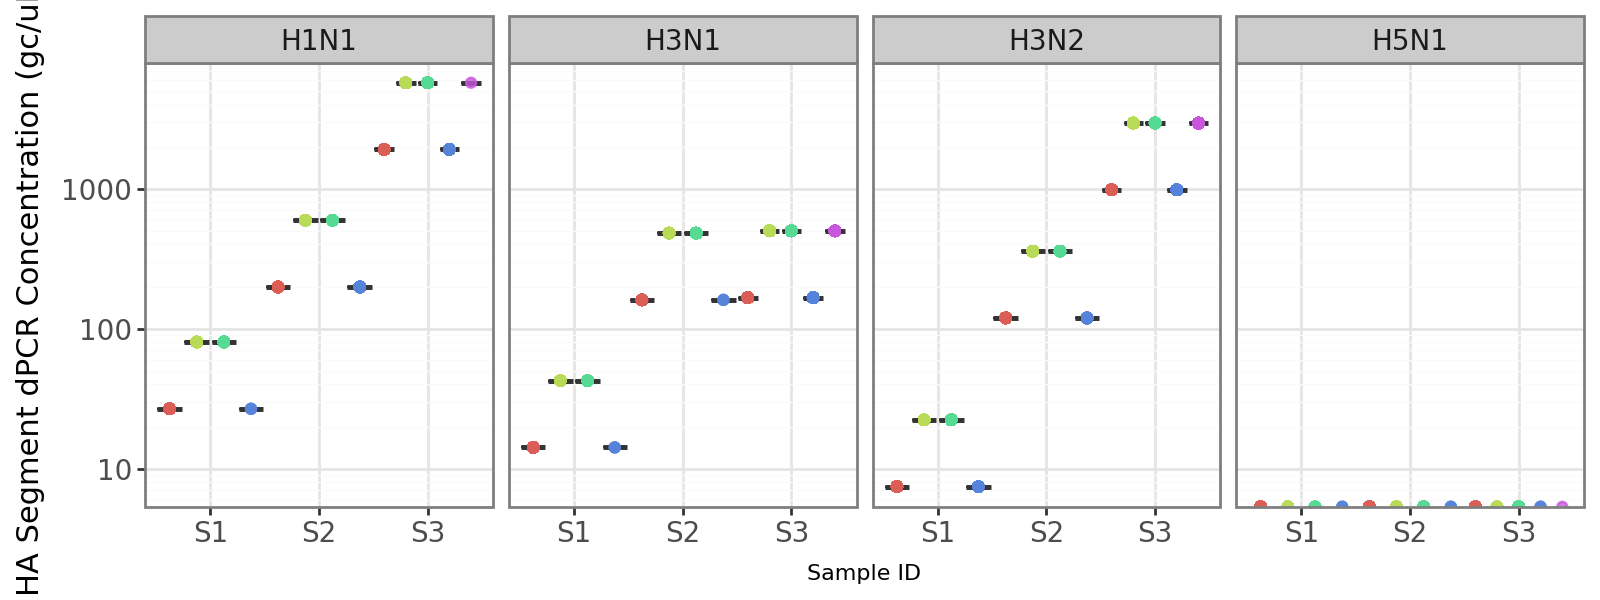

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 3 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /content/drive/My Drive/UC Berkeley/IAV_seq_results/plot1a.png
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 45775 rows containing non-finite values.


In [ ]:
plot1a = (
    ggplot(DM_HA, aes(x='sample_id', y='gene copies', fill='sequencing_method')) +
    geom_boxplot(alpha=0.8, width=1) +  # Set boxplot transparency and width
    geom_point(
        aes(color='sequencing_method'),
        position=position_dodge(width=1),  # Adjust position to align with boxplots
        size=1.5,
        alpha=0.8
    ) +
    xlab('Sample ID') +  # Capitalize 'Sample ID' for consistency
    ylab('HA Segment dPCR Concentration (gc/uL)') +  # Rephrase y-axis label for clarity
    scale_y_log10() +  # Apply log scale to y-axis
    facet_wrap('~strain', ncol=4) +  # Facet by strain, with 4 columns
    theme_bw() +  # Use black-and-white theme
    theme(
        figure_size=(8, 3),
        legend_position="none",
        axis_title_x=element_text(size=8),  # X-axis title font size
        axis_text_x=element_text(size=10),  # X-axis ticks font size
        axis_text_y=element_text(size=10),  # Y-axis ticks font size
        strip_text=element_text(size=10)  # Subplot titles (facet labels) font size
    )
)

display(plot1a)
ggsave(plot1a, filename="/content/drive/My Drive/UC Berkeley/IAV_seq_results/plot1a.png", dpi=300)


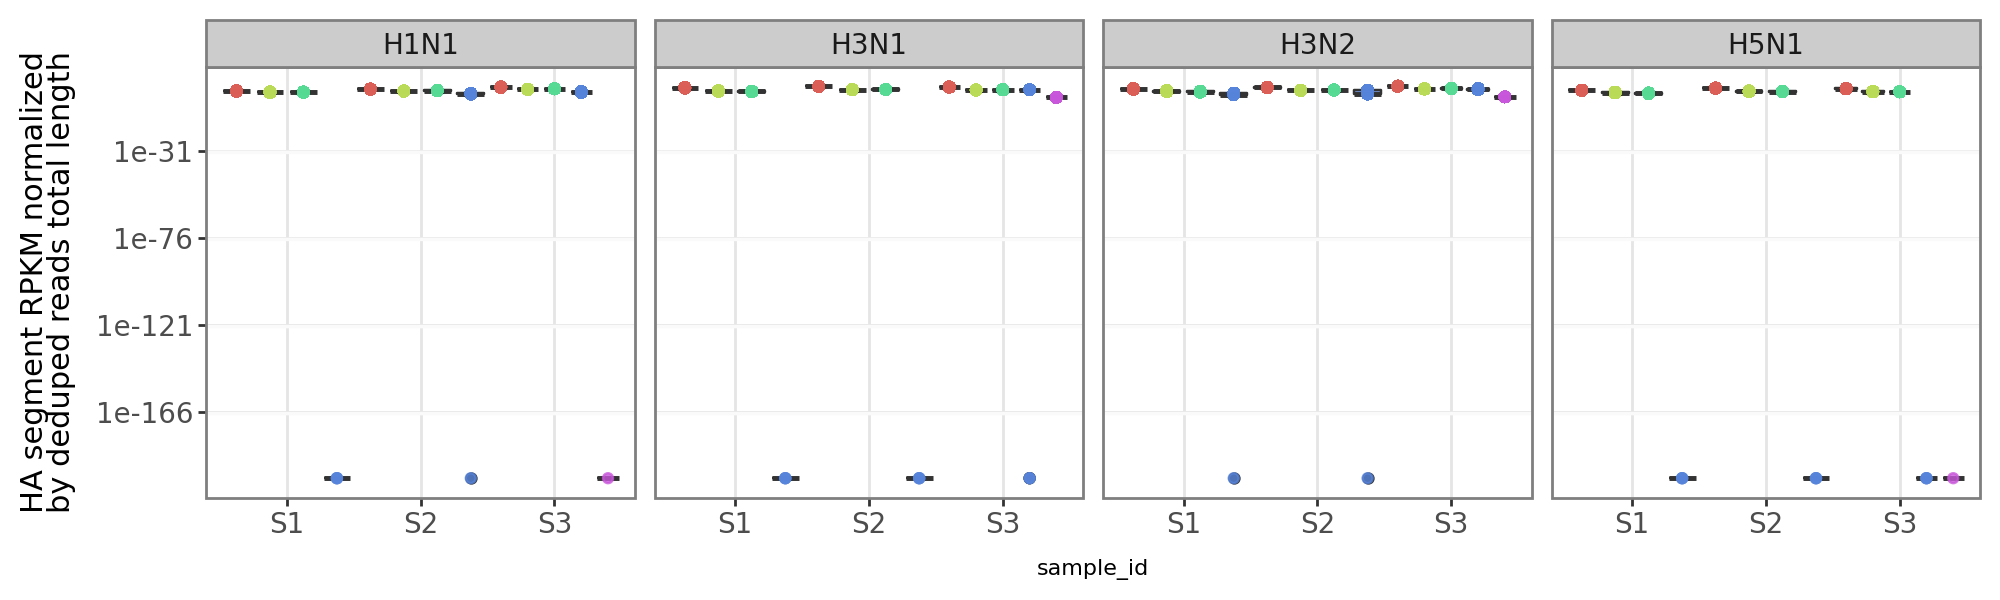

In [ ]:
DM_HA['mapped_rpkm_dedup_paired'] = DM_HA['mapped_rpkm_dedup_paired'].replace(0, 1e-20)

plot1b = (
    ggplot(DM_HA, aes(x='sample_id', y='mapped_rpkm_dedup_paired', fill='sequencing_method')) +
    geom_boxplot(alpha=0.8, width=0.8, position=position_dodge(width=1)) +
    geom_point(
    aes(color='sequencing_method'),
    position=position_dodge(width=1),
    size=1.5,
    alpha=0.8
) +
    xlab('sample_id') +
    ylab('HA segment RPKM normalized\nby deduped reads total length') +
    scale_y_log10() +  # Apply log scale to y-axis
    facet_wrap('~strain',ncol=4) +  # Facet by sample_id with free y-axis scales and 4 columns
    theme_bw() +  # Use black-and-white theme
    theme(
        figure_size=(10, 3),
        legend_position="none" ,
        axis_title_x=element_text(size=8),  # X-axis title font size
        axis_text_x=element_text(size=10),  # X-axis ticks font size
        axis_text_y=element_text(size=10),  # Y-axis ticks font size
        strip_text=element_text(size=10),  # Subplot titles (facet labels) font size
    )
)

display(plot1b)
#ggsave(plot1b, filename="/content/drive/My Drive/UC Berkeley/IAV_seq_results/plot1b.png", dpi=300)


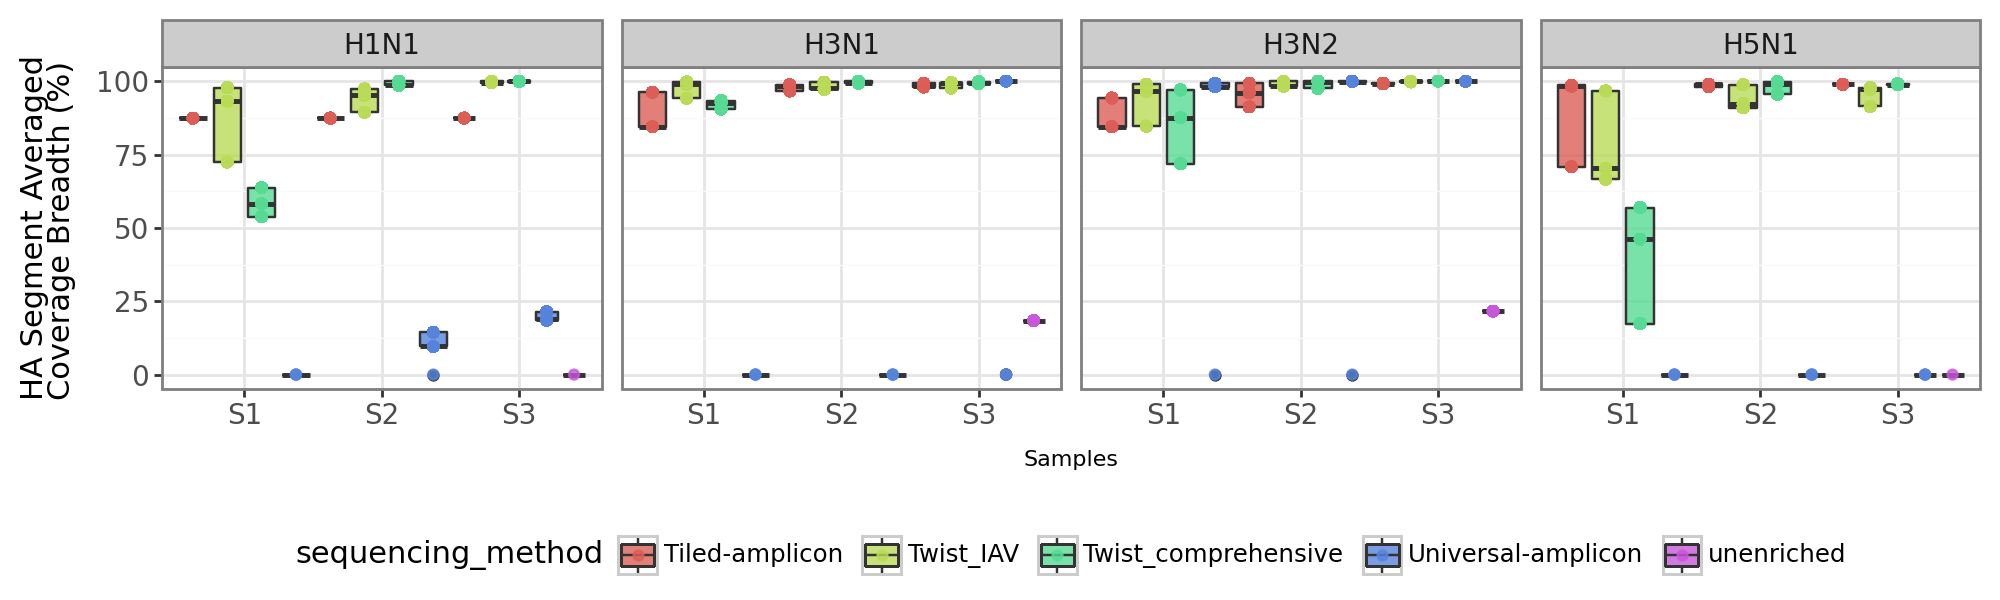

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 3 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /content/drive/My Drive/UC Berkeley/IAV_seq_results/plot1c.png


In [ ]:
plot1c = (
    ggplot(DM_HA, aes(x='sample_id', y='coverage', fill='sequencing_method')) +
    geom_boxplot(alpha=0.8, width=0.8,position=position_dodge(width=1)) +
    geom_point(
        aes(color='sequencing_method'),
        position=position_dodge(width=1),  # Match the dodge width to the boxplot width
        size=1.5,
        alpha=0.8
    ) +
    xlab('Samples') +
    ylab('HA Segment Averaged\nCoverage Breadth (%)') +
    facet_wrap('~strain',ncol=4)+
    #scale_fill_brewer(type='qual', palette='Set2') +  # Apply beautiful color palette for fill
    #scale_color_brewer(type='qual', palette='Set2') +  # Match point colors to fill colors
    theme_bw() +
     theme(
        figure_size=(10, 3),
        axis_title_x=element_text(size=8),  # X-axis title font size
        axis_text_x=element_text(size=10),# X-axis ticks font size
         legend_position='bottom' ,
        axis_text_y=element_text(size=10),  # Y-axis ticks font size
        strip_text=element_text(size=10),  # Subplot titles (facet labels) font size
    )
)

display(plot1c)
ggsave(plot1c, filename="/content/drive/My Drive/UC Berkeley/IAV_seq_results/plot1c.png", dpi=300)


In [ ]:
DM_depth = calculated_final[calculated_final.sample_id.isin(['S1', 'S2', 'S3','S4'])].copy() # drop S4, which was spiked with a different H5N1 genome

# Step 1: Replace zeros and negatives to avoid log10 issues
DM_depth['log_DP_rpkm_dedup_paired'] = DM_depth['DP_rpkm_dedup_paired'].copy()
DM_depth.loc[DM_depth['DP_rpkm_dedup_paired'] == 0, 'log_DP_rpkm_dedup_paired'] = np.nan  # Replace zero coverage with NaN

# Step 2: Apply log10 transformation only to valid (positive) values
DM_depth['log_DP_rpkm_dedup_paired'] = np.log10(DM_depth['log_DP_rpkm_dedup_paired'])

# Step 3: Replace NaNs with zero for plotting
#DM_depth['log_DP_rpkm_dedup_paired'] = DM_depth['log_DP_rpkm_dedup_paired'].fillna(0)

# Step 4: Ensure all required columns are numeric
DM_depth['POSITION'] = pd.to_numeric(DM_depth['POSITION'], errors='coerce')

# check: Universal-amplicon, does those unplotted position is zero coverage or what?
check=DM_depth[(DM_depth['log_DP_rpkm_dedup_paired']==0)&(DM_depth['sequencing_method']=='Universal-amplicon')]
check

Empty DataFrame
Columns: [sample_name, sample_id, library_id, WW_method, strain, dPCR_postFreeze_thaw_gc_ul, sequencing_method, segment, coverage, total_len, covbases, mean_depth, mapped_reads, cutadapt, deduplicated, filtered, paired, raw, accession, POSITION, COVERAGE, method, segment_number, mapped_rpkm_dedup_paired, mapped_rpkm_raw, DP_rpkm_dedup_paired, DP_rpkm_raw, gene copies, log_DP_rpkm_dedup_paired]
Index: []

[0 rows x 29 columns]

In [ ]:
# Define the desired order of segments
segment_order = ['PB2', 'PB1', 'PA', 'HA', 'NP', 'NA', 'MP', 'NS']

# Convert the 'segment' column to a categorical variable with the specified order
DM_depth['segment'] = pd.Categorical(DM_depth['segment'], categories=segment_order, ordered=True)
DM_depth_S1 = DM_depth[DM_depth.sample_id == 'S1'].copy()
DM_depth_S2 = DM_depth[DM_depth.sample_id == 'S2'].copy()
DM_depth_HA=DM_depth[DM_depth.segment=='HA']
DM_depth_HA.head()

sample_name sample_id library_id WW_method strain  \
1574000       S1_31        S1         31        DM   H1N1   
1578560       S1_31        S1         31        DM   H3N1   
1578568       S1_31        S1         31        DM   H3N2   
1578569       S1_31        S1         31        DM   H3N2   
1578570       S1_31        S1         31        DM   H3N2   

         dPCR_postFreeze_thaw_gc_ul   sequencing_method segment  coverage  \
1574000                       5.352  Universal-amplicon      HA    0.0000   
1578560                       2.836  Universal-amplicon      HA    0.0000   
1578568                       1.488  Universal-amplicon      HA   98.1591   
1578569                       1.488  Universal-amplicon      HA   98.1591   
1578570                       1.488  Universal-amplicon      HA   98.1591   

         total_len  ...  POSITION  COVERAGE              method  \
1574000     1701.0  ...       NaN       NaN                 NaN   
1578560     1684.0  ...       NaN       NaN                 NaN   
1578568     1684.0  ...       1.0         1  Universal-amplicon   
1578569     1684.0  ...       2.0         1  Universal-amplicon   
1578570     1684.0  ...       3.0         1  Universal-amplicon   

         segment_number  mapped_rpkm_dedup_paired  mapped_rpkm_raw  \
1574000             NaN                  0.000000            0.000   
1578560             NaN                  0.000000            0.000   
1578568             4.0                  0.084503            0.004   
1578569             4.0                  0.084503            0.004   
1578570             4.0                  0.084503            0.004   

         DP_rpkm_dedup_paired  DP_rpkm_raw gene copies  \
1574000                   NaN          NaN       26.76   
1578560                   NaN          NaN       14.18   
1578568             142.30344     6.735645        7.44   
1578569             142.30344     6.735645        7.44   
1578570             142.30344     6.735645        7.44   

         log_DP_rpkm_dedup_paired  
1574000                       NaN  
1578560                       NaN  
1578568                  2.153215  
1578569                  2.153215  
1578570                  2.153215  

[5 rows x 29 columns]

/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 23970 rows containing missing values.


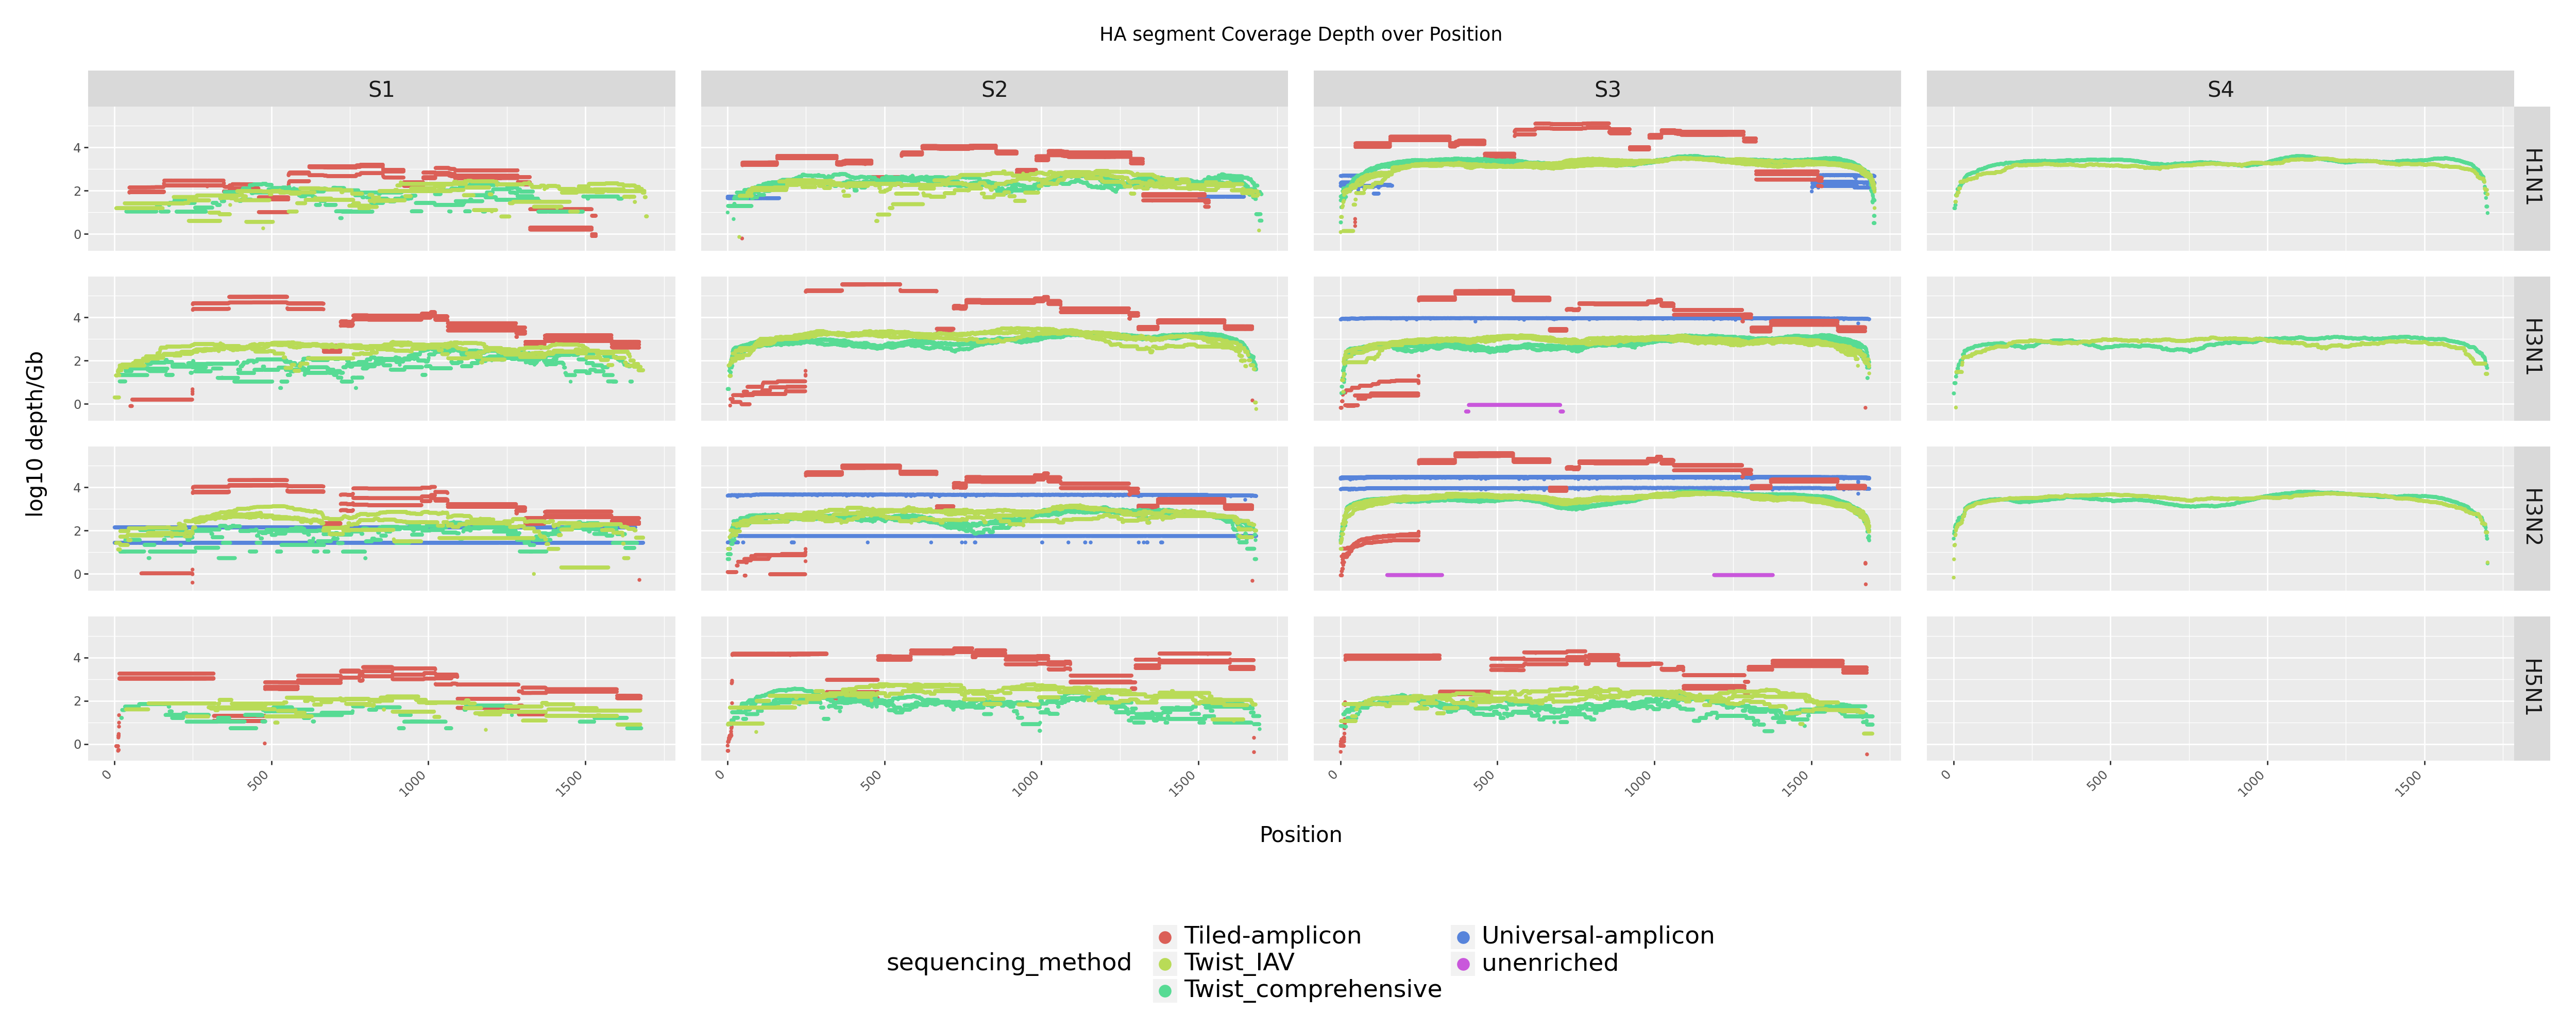

In [ ]:
# Plot with the specified segment order
plot3 = (
    ggplot(DM_depth_HA, aes(x='POSITION', y='log_DP_rpkm_dedup_paired', color='sequencing_method')) +
    geom_point(size=0.5) +  # Dot plot
    facet_grid('strain ~ sample_id') +  # Facet by strain and segment
    labs(
        x='Position',
        y='log10 depth/Gb',
        title='HA segment Coverage Depth over Position'
    ) +
    theme(
        figure_size=(25, 10),  # Adjust the figure size
        axis_text_x=element_text(rotation=45, ha='right'),  # Rotate x-axis labels for readability
        axis_title_x=element_text(size=15),
        axis_title_y=element_text(size=15),
        strip_text=element_text(size=15),  # Font size for facet titles
        legend_position='bottom' , # Move the legend to the top
        legend_text=element_text(size=17),  # Font size for legend labels
        legend_title=element_text(size=17)  # Font size for legend title
    )
)

plot3 += guides(
    fill=guide_legend(ncol=2, override_aes={'size': 4}),  # Adjust point size in legend
    color=guide_legend(ncol=2, override_aes={'size': 4})  # Adjust point size in legend for color
)

display(plot3)

In [ ]:
ggsave(plot3, filename="/content/drive/My Drive/UC Berkeley/IAV_seq_results/plot3.png", dpi=300)

/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 25 x 10 in image.
/usr/local/lib/python3.11/dist-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /content/drive/My Drive/UC Berkeley/IAV_seq_results/plot3.png
/usr/local/lib/python3.11/dist-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 3 rows containing missing values.


In [ ]:
# Group data by sample_id, segment, and sequencing_method for easy plotting
grouped_data = DM_H3N1.groupby(['sample_id', 'segment', 'sequencing_method'])

# Define sample IDs and segments
sample_ids = DM_H3N1['sample_id'].unique()
segments = DM_H3N1['segment'].dropna().unique()
# Define a custom order for sample_id (example)
custom_sample_order = ['S1', 'S2', 'S3','S4']  # Example custom order, replace with your desired order
# Sort sample_ids according to the custom order
sample_ids = sorted(sample_ids, key=lambda x: custom_sample_order.index(x) if x in custom_sample_order else len(custom_sample_order))
segments

array(['HA', 'MP', 'NA', 'NP', 'NS', 'PA', 'PB1', 'PB2'], dtype=object)

In [ ]:
# Convert columns to numeric types in the main DataFrame
DM_H3N1['POSITION'] = pd.to_numeric(DM_H3N1['POSITION'], errors='coerce')
DM_H3N1['DP_rpkm_dedup_paired'] = pd.to_numeric(DM_H3N1['DP_rpkm_dedup_paired'], errors='coerce')

# Drop rows with NaN values in these columns (if necessary)
DM_H3N1 = DM_H3N1.dropna(subset=['POSITION', 'DP_rpkm_dedup_paired'])

<ipython-input-227-549a320909b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-227-549a320909b7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<ipython-input-234-ada945f5dd23>:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.


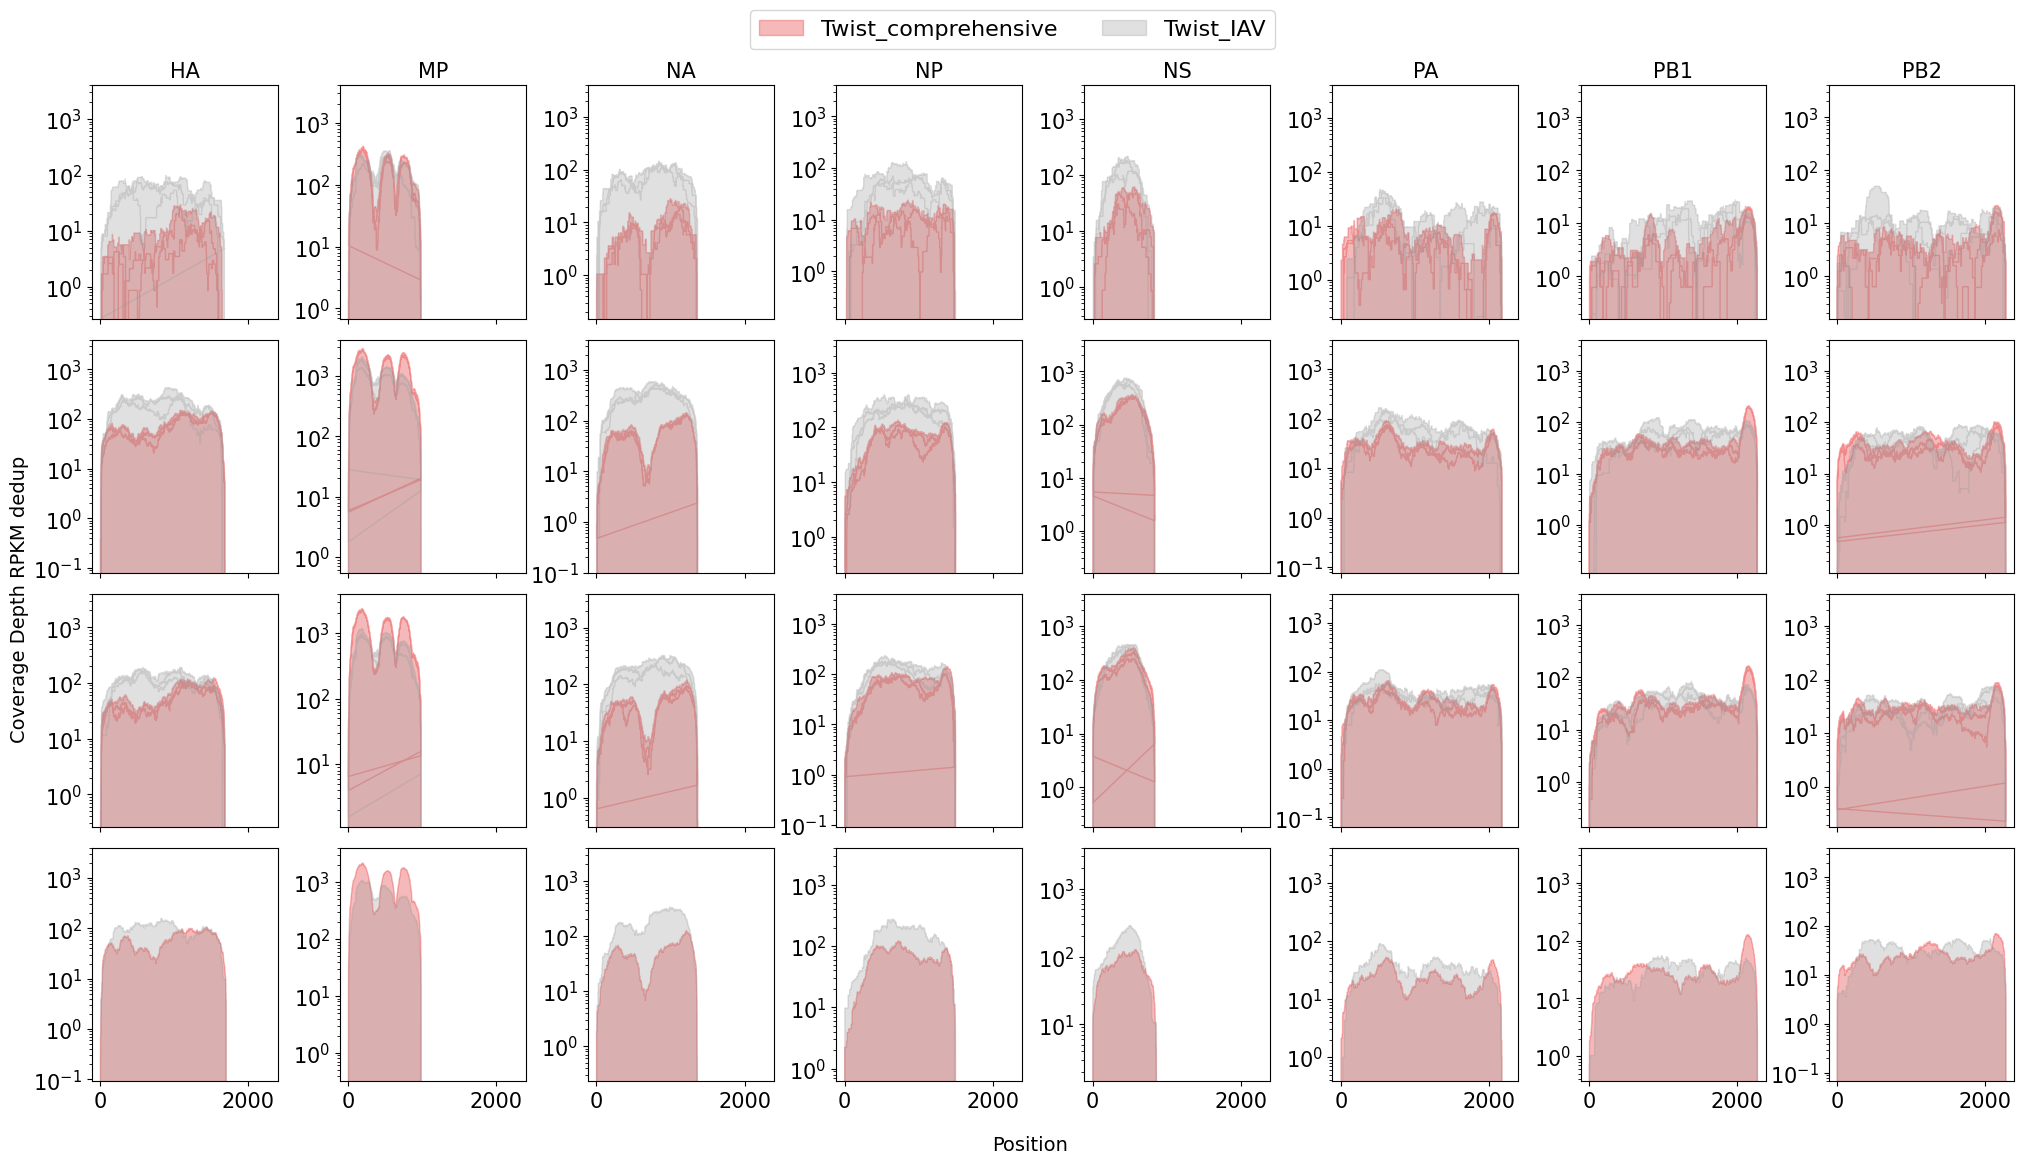

In [ ]:
# Set up figure size and grid layout (rows: sample IDs, columns: segments)
fig, axes = plt.subplots(nrows=len(sample_ids), ncols=len(segments), figsize=(20, 12), sharex=True, sharey=False)

# Flatten axes for easy iteration
axes = axes.flatten()

# Define a function to plot shadow plots
def plot_shadow(ax, df, title, color, label):
    positions = df['POSITION']
    coverage = df['DP_rpkm_dedup_paired']

    # Plot coverage depth with the provided color
    ax.fill_between(positions, coverage, color=color, alpha=0.3, label=label)

    # Dynamically set the y-axis limit based on the data
    #ax.set_ylim(0, coverage.max() * 1.1)  # 10% higher than max coverage for better visualization
    ax.set_ylim(0, 4000)

    ax.set_title(title, fontsize=15)
    ax.set_yscale('log')

# Generate a color map with a different color for each unique sequencing method
unique_methods = DM_H3N1['sequencing_method'].unique()
colors = plt.cm.Set1(np.linspace(0, 0.9, len(unique_methods)))  # Using Set2 colormap

# Create a mapping from sequencing method to color and label
method_to_color = {
    "Twist_comprehensive": colors[0],  # First color for Twist_comprehensive
    "Twist_IAV": colors[1]            # Second color for Twist_IAV
}

method_to_label = {
    "Twist_comprehensive": "Twist_comprehensive",
    "Twist_IAV": "Twist_IAV"
}

# Loop through each sample_id and segment to plot
for i, sample_id in enumerate(sample_ids):
    for j, segment in enumerate(segments):
        # Loop through all sequencing methods for the current sample_id and segment
        for sequencing_method in unique_methods:
            # Filter data for the specific sample_id, segment, and sequencing_method
            try:
                df_filtered = grouped_data.get_group((sample_id, segment, sequencing_method))
            except KeyError:
                # Skip if no data is available for the combination
                continue

            # Determine the subplot index
            ax = axes[i * len(segments) + j]

            # Get the color for the current sequencing method
            color = method_to_color[sequencing_method]
            label = method_to_label[sequencing_method]  # Get the corresponding label for the legend

            # Plot shadow plot
            title = "" if i > 0 else segment  # Title only for the top row
            plot_shadow(ax, df_filtered, title, color, label)

            # Set tick parameters with a specific font size
            ax.tick_params(axis='both', labelsize=15)  # Set font size for both x and y ticks

# Add global x and y labels
fig.text(0.5, 0.04, 'Position', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Coverage Depth RPKM dedup', va='center', rotation='vertical', fontsize=14)

# Add a single global legend for the entire figure
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=16)

# Adjust layout and add global title
fig.tight_layout(rect=[0, 0.06, 1, 0.96])

# Show the plot
plt.show()

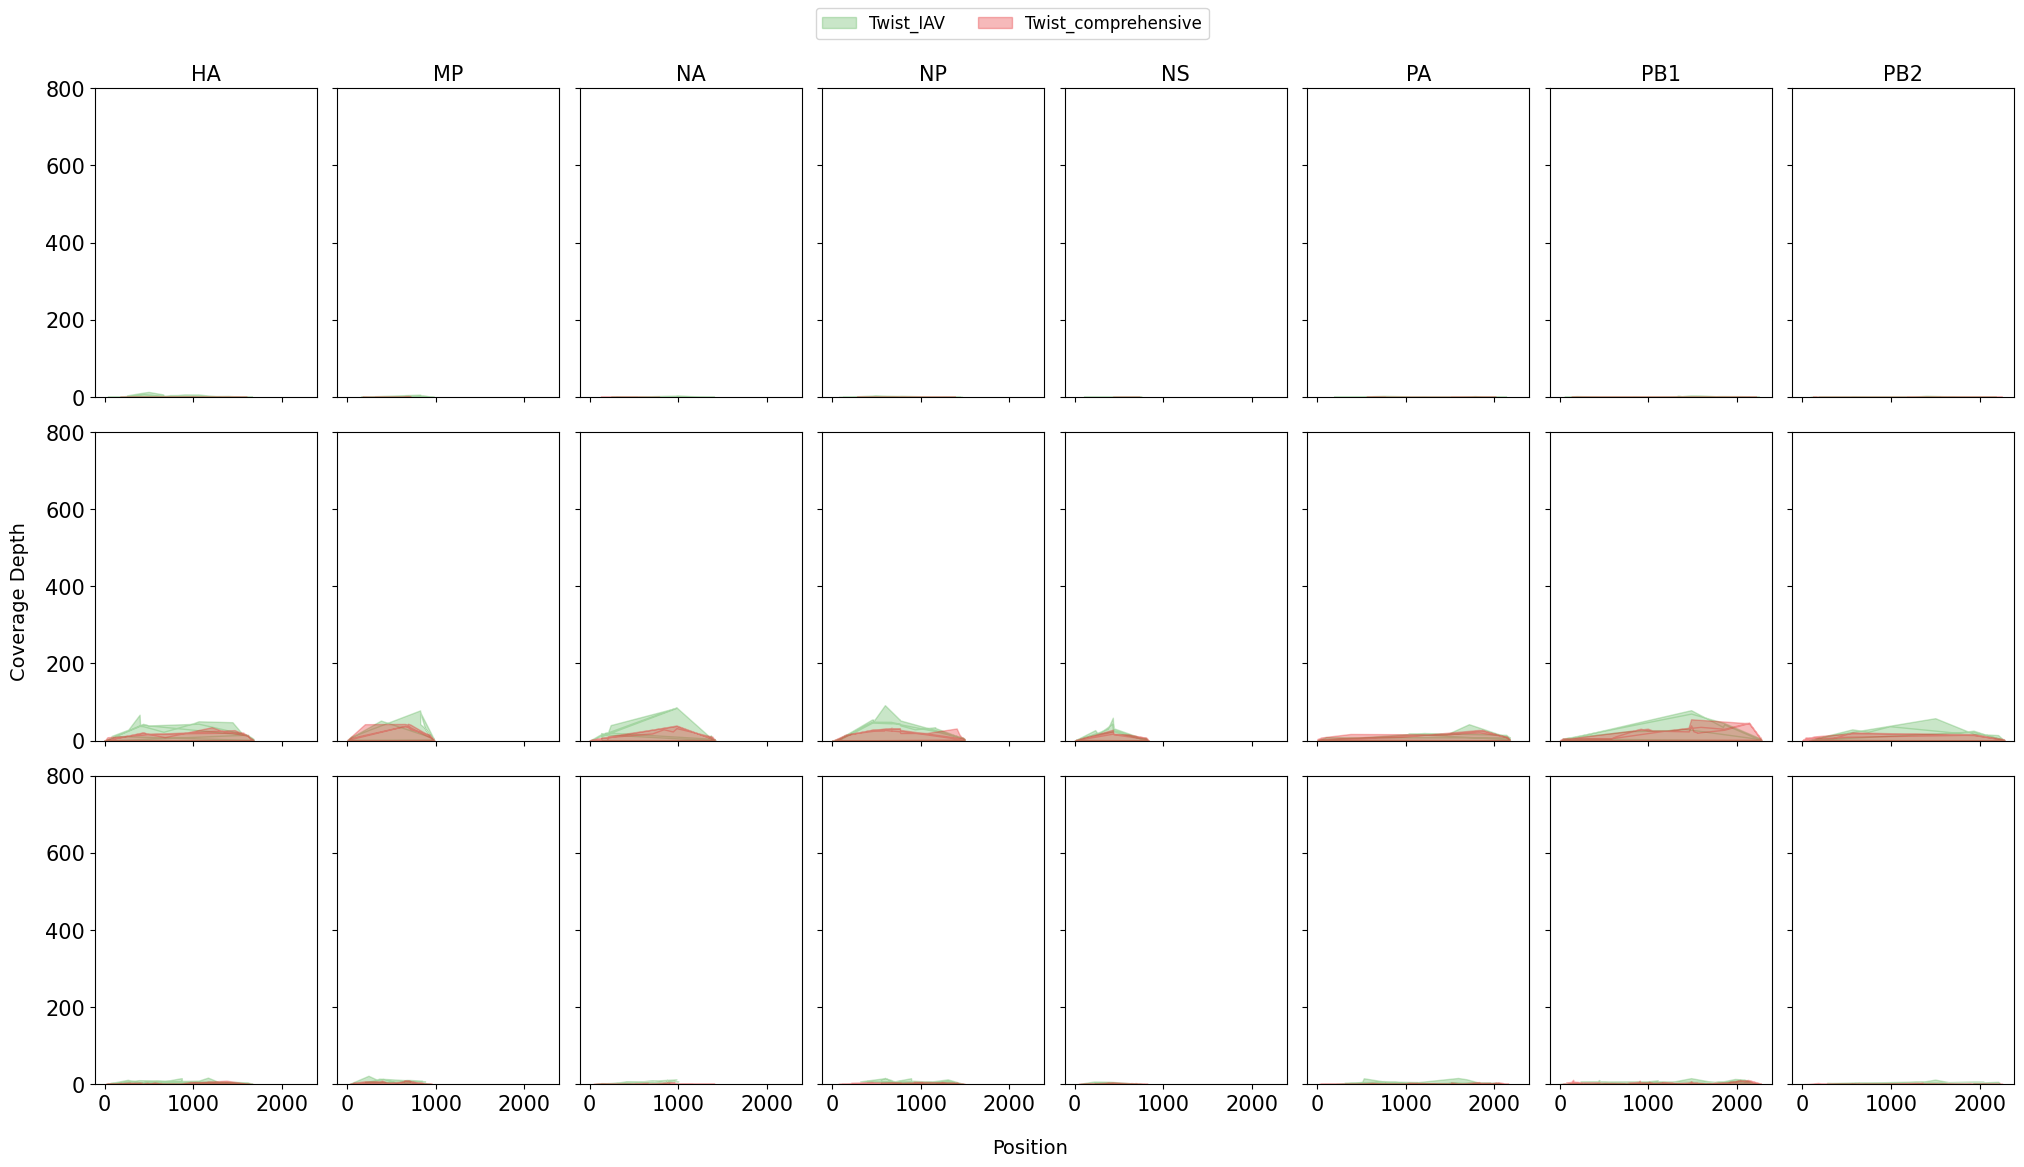

In [ ]:
# Set up figure size and grid layout (rows: sample IDs, columns: segments)
fig, axes = plt.subplots(nrows=len(sample_ids), ncols=len(segments), figsize=(20, 12), sharex=True, sharey=True)

# Flatten axes for easy iteration
axes = axes.flatten()

# Define a function to plot shadow plots
def plot_shadow(ax, df, title, color, label):
    positions = df['POS']
    coverage = df['DP_rpkm_dedup_paired']

    # Plot coverage depth with the provided color
    ax.fill_between(positions, coverage, color=color, alpha=0.3, label=label)

    # Dynamically set the y-axis limit based on the data
    #ax.set_ylim(0, coverage.max() * 1.1)  # 10% higher than max coverage for better visualization
    ax.set_ylim(0, 800)

    ax.set_title(title, fontsize=15)

# Generate a color map with a different color for each unique sequencing method
unique_methods = DM['sequencing_method'].unique()
colors = plt.cm.Set1(np.linspace(0, 0.9, len(unique_methods)))  # Using Set1 colormap

# Create a mapping from sequencing method to color and label
method_to_color = {
    "Twist_comprehensive": colors[0],  # First color for Twist_comprehensive
    "Twist_IAV": colors[1],            # Second color for Twist_IAV
    "Tiled-amplicon": colors[2]        # Third color for Tiled-amplicon
}

method_to_label = {
    "Twist_comprehensive": "Twist_comprehensive",
    "Twist_IAV": "Twist_IAV",
    "Tiled-amplicon": "Tiled-amplicon"
}

# Loop through each sample_id and segment to plot
for i, sample_id in enumerate(sample_ids):
    for j, segment in enumerate(segments):
        # Loop through all sequencing methods for the current sample_id and segment
        for sequencing_method in unique_methods:
            # Filter data for the specific sample_id, segment, and sequencing_method
            try:
                df_filtered = grouped_data.get_group((sample_id, segment, sequencing_method))
            except KeyError:
                # Skip if no data is available for the combination
                continue

            # Determine the subplot index
            ax = axes[i * len(segments) + j]

            # Get the color for the current sequencing method
            color = method_to_color[sequencing_method]
            label = method_to_label[sequencing_method]  # Get the corresponding label for the legend

            # Plot shadow plot
            title = "" if i > 0 else segment  # Title only for the top row
            plot_shadow(ax, df_filtered, title, color, label)

            # Set tick parameters with a specific font size
            ax.tick_params(axis='both', labelsize=15)  # Set font size for both x and y ticks

# Add global x and y labels
fig.text(0.5, 0.04, 'Position', ha='center', fontsize=14)
fig.text(-0.01, 0.5, 'Coverage Depth', va='center', rotation='vertical', fontsize=14)

# Add a single global legend for the entire figure
handles, labels = axes[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=12)

# Adjust layout and add global title
fig.tight_layout(rect=[0, 0.06, 1, 0.96])

# Show the plot
plt.show()



# **Incubation analysis **

In [ ]:
IM =calculated_final[calculated_final.sample_id.isin(['IP_0h_1', 'IP_3h_1', 'IP_3h_2' ,'IP_3h_3' ,'PMG_0h_1',
 'PMG_3h_1', 'PMG_3h_3' ,'PMG_3h_2'])].copy()
# Update 'gene copies' column based on the condition
IM['gene copies'] = np.where(
    IM['sequencing_method'].isin(['twist_IAV', 'twist_comprehensive', 'unenriched']),
    IM['dPCR_postFreeze_thaw_gc_ul'] * 15,
    IM['dPCR_postFreeze_thaw_gc_ul'] * 5
)

IM.head()

sample_name sample_id library_id WW_method strain  \
1390963  IP_0h_1_65   IP_0h_1         65        IP   H1N1   
1390964  IP_0h_1_65   IP_0h_1         65        IP   H1N1   
1390965  IP_0h_1_65   IP_0h_1         65        IP   H1N1   
1390966  IP_0h_1_65   IP_0h_1         65        IP   H1N1   
1390967  IP_0h_1_65   IP_0h_1         65        IP   H1N1   

         dPCR_postFreeze_thaw_gc_ul sequencing_method   cutadapt  \
1390963                       704.0    Tiled-amplicon  1789156.0   
1390964                       704.0    Tiled-amplicon  1789156.0   
1390965                       704.0    Tiled-amplicon  1789156.0   
1390966                       704.0    Tiled-amplicon  1789156.0   
1390967                       704.0    Tiled-amplicon  1789156.0   

         deduplicated   filtered  ...  COVERAGE          method  \
1390963           NaN  2737216.0  ...         0  Tiled-amplicon   
1390964           NaN  2737216.0  ...         0  Tiled-amplicon   
1390965           NaN  2737216.0  ...         0  Tiled-amplicon   
1390966           NaN  2737216.0  ...         0  Tiled-amplicon   
1390967           NaN  2737216.0  ...         0  Tiled-amplicon   

         segment_number  mapped_rpkm_dedup_paired  mapped_rpkm_raw  \
1390963             4.0              58897.840682     38009.569009   
1390964             4.0              58897.840682     38009.569009   
1390965             4.0              58897.840682     38009.569009   
1390966             4.0              58897.840682     38009.569009   
1390967             4.0              58897.840682     38009.569009   

         mapped_rpkm_undedupe  DP_rpkm_dedup_paired DP_rpkm_raw  \
1390963          38498.030497                   0.0         0.0   
1390964          38498.030497                   0.0         0.0   
1390965          38498.030497                   0.0         0.0   
1390966          38498.030497                   0.0         0.0   
1390967          38498.030497                   0.0         0.0   

        DP_rpkm_undedupe gene copies  
1390963              0.0      3520.0  
1390964              0.0      3520.0  
1390965              0.0      3520.0  
1390966              0.0      3520.0  
1390967              0.0      3520.0  

[5 rows x 30 columns]

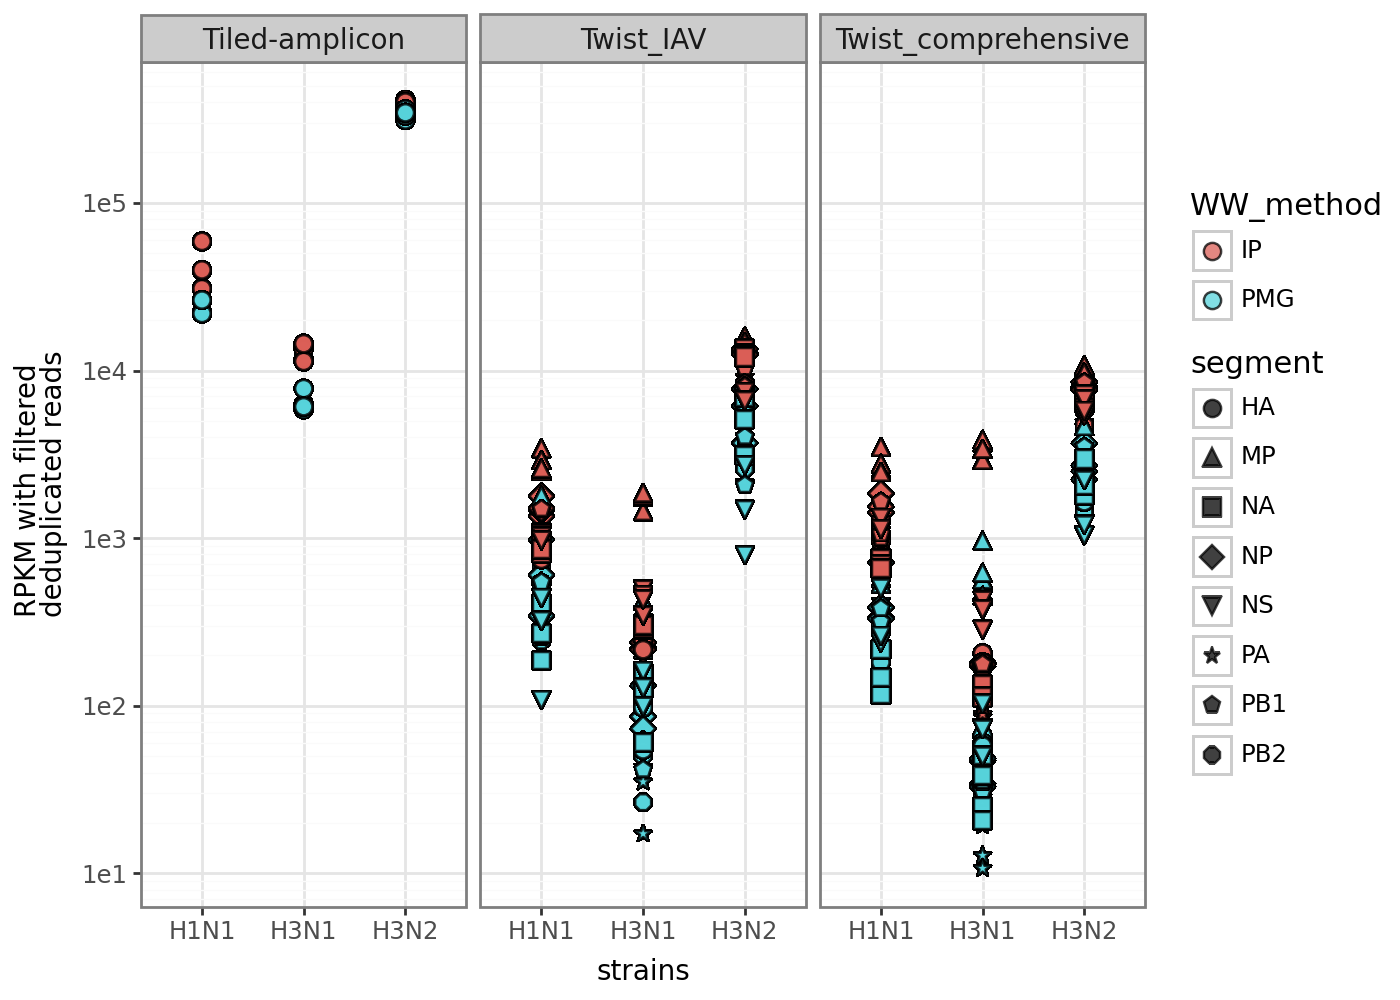

In [ ]:
plot4 = (ggplot(IM, aes(x='strain', y='mapped_rpkm_dedup_paired', fill='WW_method', shape='segment'))+
     geom_point(alpha=0.75, size=3)+
     #scale_x_log10()+
     scale_y_log10()+
      xlab('strains')+
     ylab('RPKM with filtered\ndeduplicated reads')+
    facet_wrap('~sequencing_method')+
     theme_bw()+
 theme(figure_size=(7,5),axis_title_x=element_text(size=10),
        axis_title_y=element_text(size=10),
        strip_text=element_text(size=10)  # Font size for facet titles)
))
display(plot4)
# ggsave(plot1, '/Users/kantor4/data/sharp/ucb_iav/twist_comp/rpkm_vs_gc.pdf')

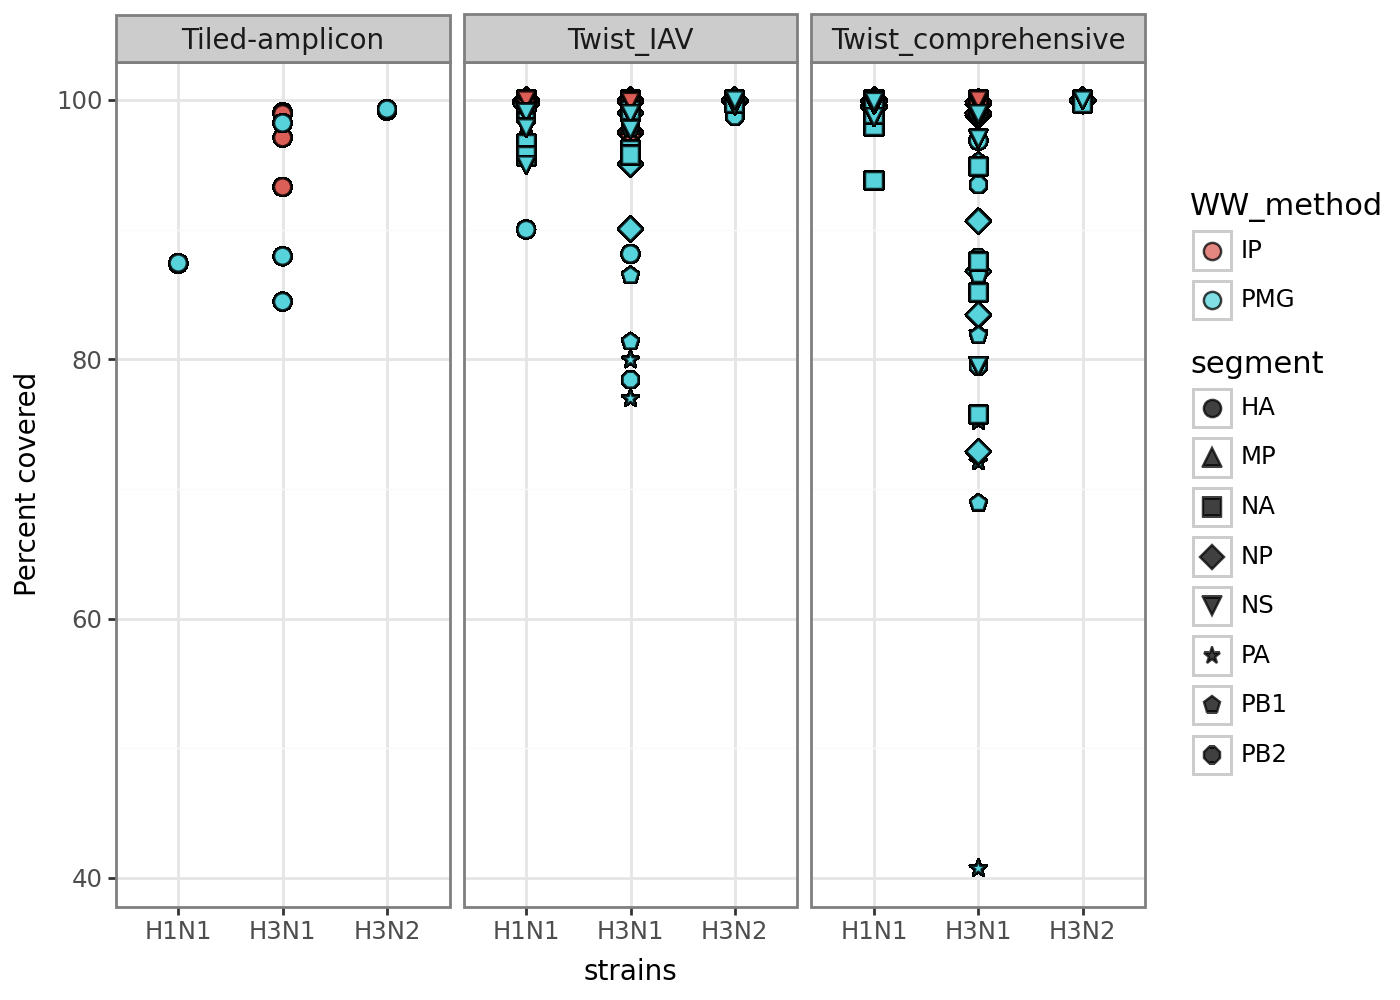

In [ ]:
plot5 = (ggplot(IM, aes(x='strain', y='coverage', fill='WW_method', shape='segment'))+ #
     geom_point(alpha=0.75, size=3)+
    # scale_x_log10()+
     xlab('strains')+
     ylab('Percent covered')+
      #scale_y_log10()+
    facet_wrap('~sequencing_method')+
     theme_bw()+
     theme(figure_size=(7,5),axis_title_x=element_text(size=10),
        axis_title_y=element_text(size=10),
        strip_text=element_text(size=10)
))
display(plot5)
# ggsave(plot2, '/Users/kantor4/data/sharp/ucb_iav/twist_comp/perccov_vs_gc.pdf')

In [ ]:
# Step 1: Replace zeros and negatives to avoid log10 issues
IM['log_DP_rpkm_dedup_paired'] = IM['DP_rpkm_dedup_paired'].copy()
IM.loc[IM['DP_rpkm_dedup_paired'] <= 0, 'log_DP_rpkm_dedup_paired'] = np.nan  # Replace zeros/negatives with NaN

# Step 2: Apply log10 transformation only to valid (positive) values
IM['log_DP_rpkm_dedup_paired'] = np.log10(IM['log_DP_rpkm_dedup_paired'])

# Step 3: Replace NaNs with explicit zero for plotting
IM['log_DP_rpkm_dedup_paired'] = IM['log_DP_rpkm_dedup_paired'].fillna(0)

# Step 4: Ensure all required columns are numeric
IM['POSITION'] = pd.to_numeric(IM['POSITION'], errors='coerce')

# Create a new column to group sample_ids
IM['sample_group'] = IM['sample_id'].replace({
    'IP_0h_1': 'IP_0h',
    'IP_3h_1': 'IP_3h',
    'IP_3h_2': 'IP_3h',
    'IP_3h_3': 'IP_3h',
    'PMG_0h_1': 'PMG_0h',
    'PMG_3h_1': 'PMG_3h',
    'PMG_3h_2': 'PMG_3h',
    'PMG_3h_3': 'PMG_3h'
})

IM_tiled=IM[IM.sequencing_method == 'Tiled-amplicon'].copy()
IM_comp=IM[IM.sequencing_method == 'Twist_comprehensive'].copy()
IM_IAV=IM[IM.sequencing_method == 'Twist_IAV'].copy()

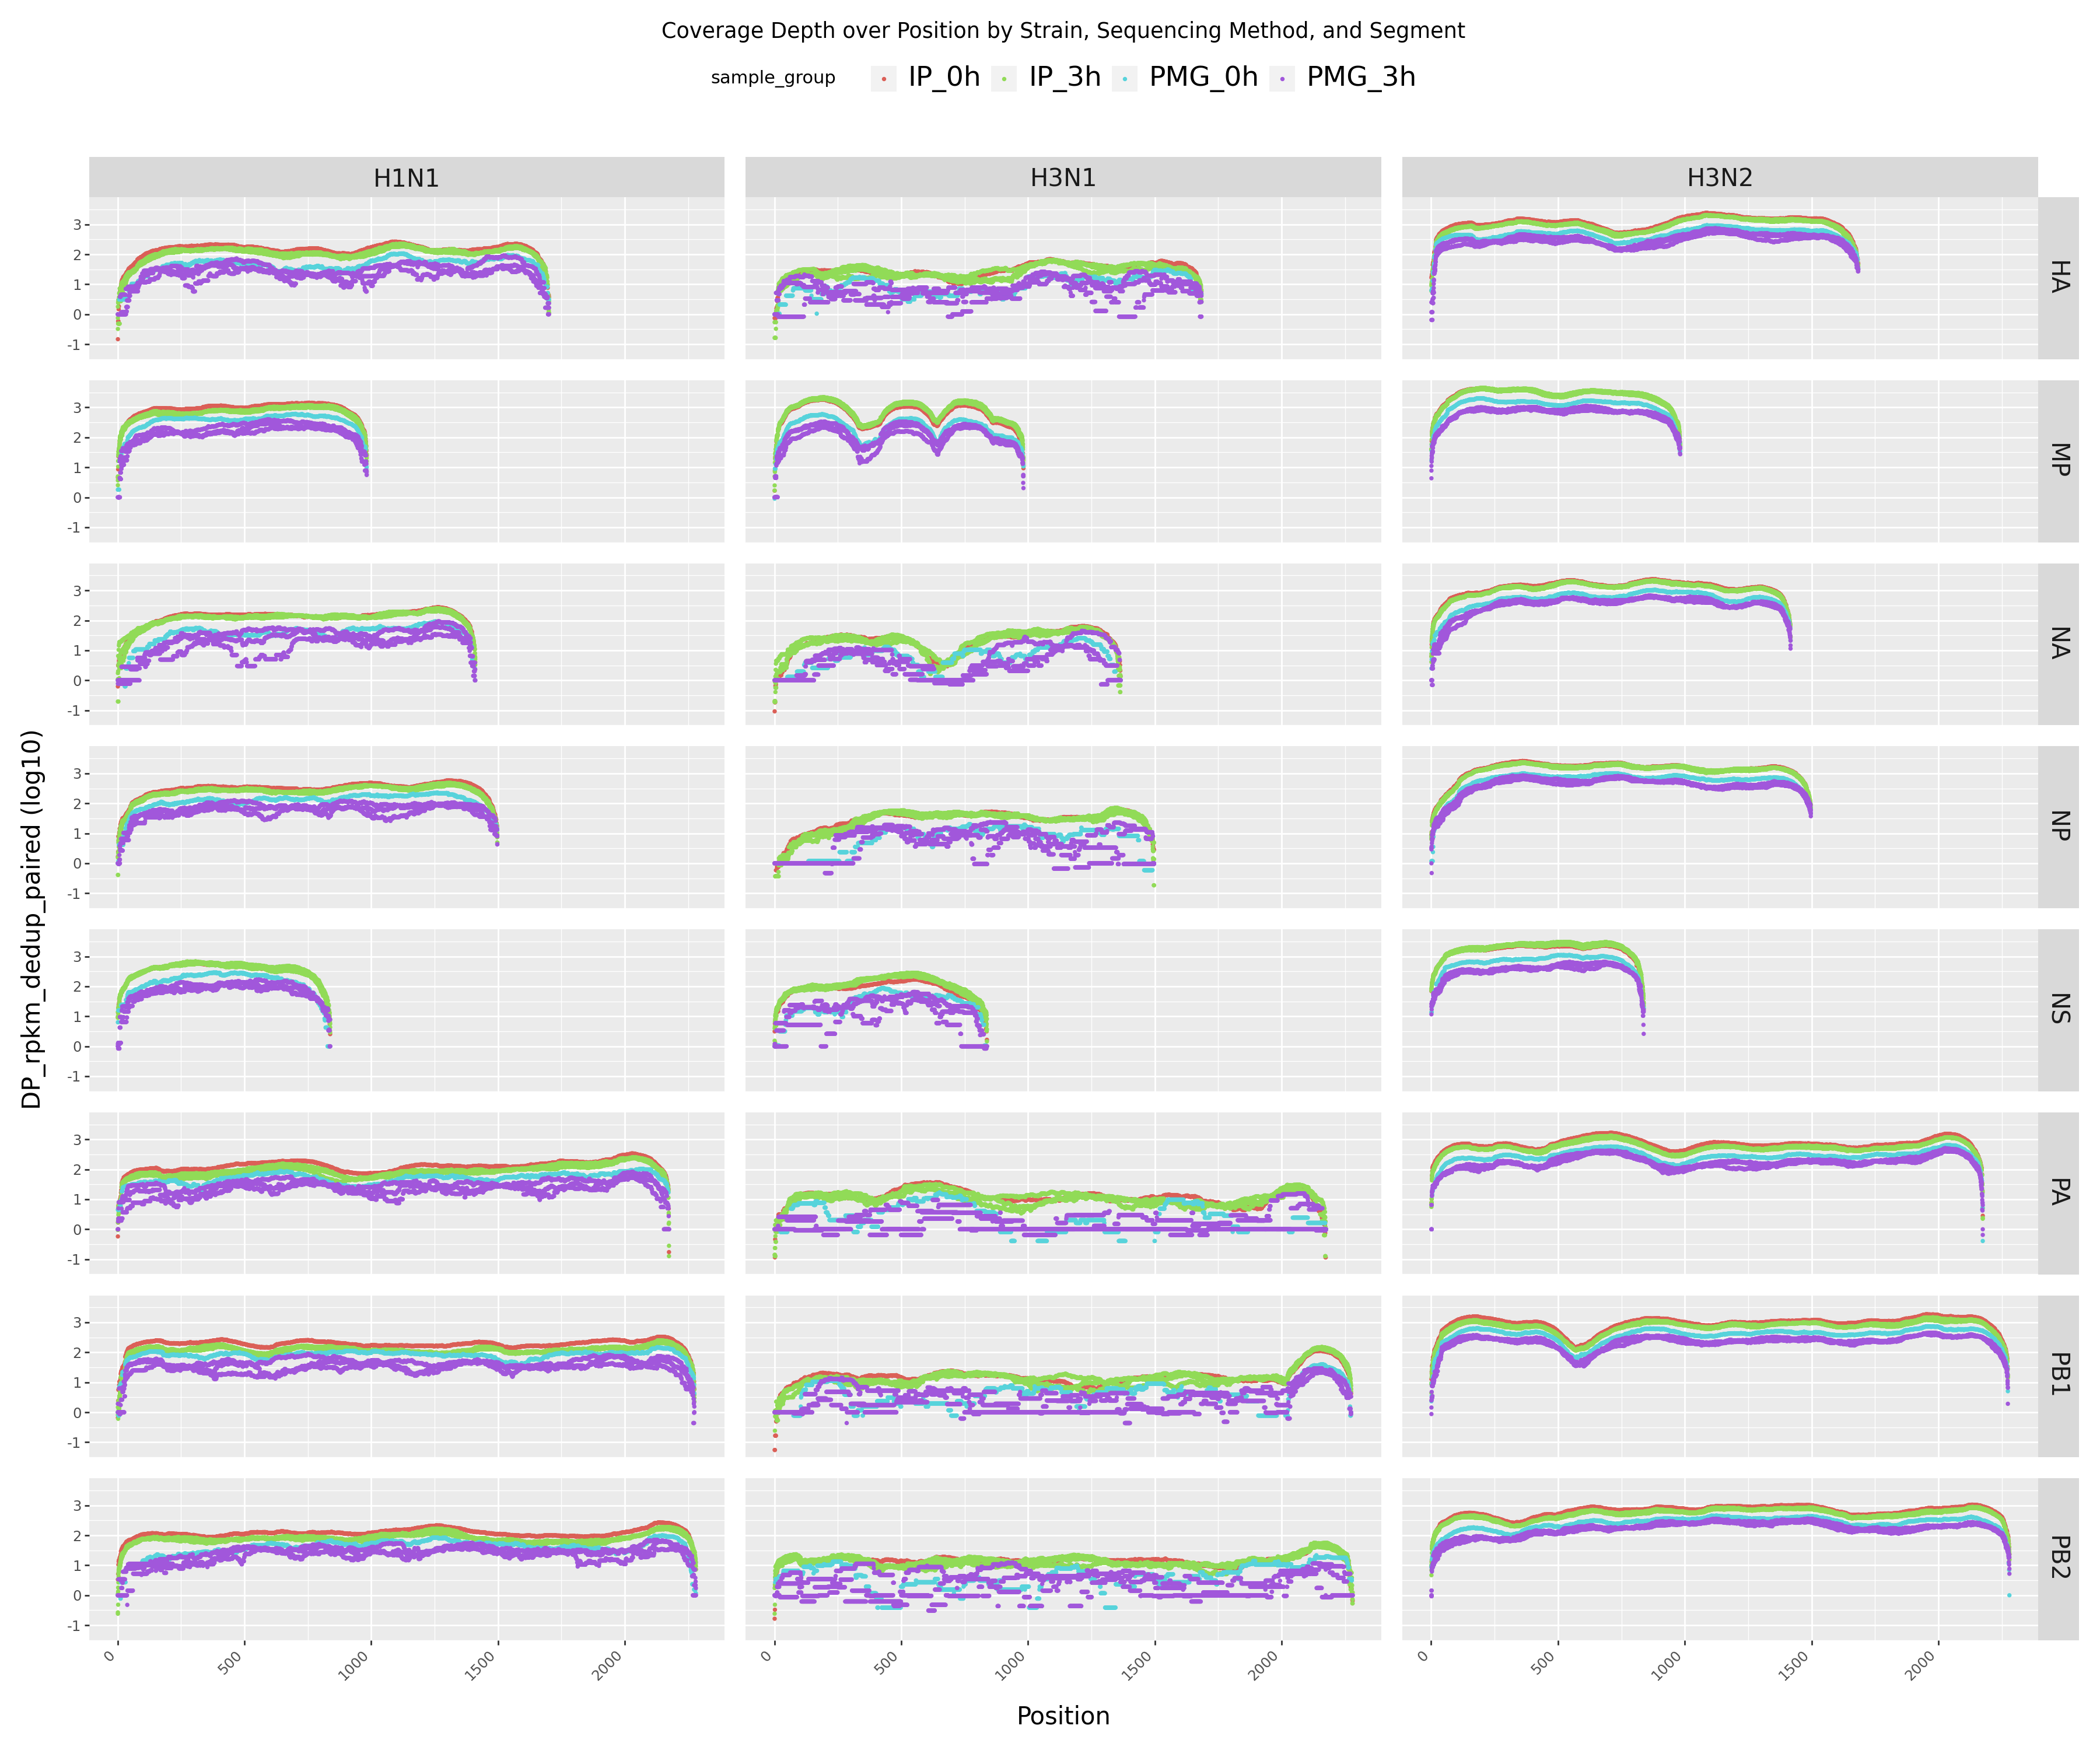

In [ ]:
# Plot with the updated grouping
plot6 = (
    ggplot(IM_comp, aes(x='POSITION', y='log_DP_rpkm_dedup_paired', color='sample_group')) +
    geom_point(size=0.5) +  # Dot plot
    facet_grid('segment ~ strain') +  # Facet by strain and segment
    labs(
        x='Position',
        y='DP_rpkm_dedup_paired (log10)',
        title='Coverage Depth over Position by Strain, Sequencing Method, and Segment'
    ) +
    theme(
        figure_size=(18, 15),  # Adjust the figure size
        axis_text_x=element_text(rotation=45, ha='right'),  # Rotate x-axis labels for readability
        axis_title_x=element_text(size=15),
        axis_title_y=element_text(size=15),
        strip_text=element_text(size=15),  # Font size for facet titles
        legend_position='top',  # Move the legend to the top
        legend_text=element_text(size=17)  # Font size for legend labels
    )
)

display(plot6)


In [ ]:
# # summarize dPCR data to have this as a presentation table

# samples_summary_df = physical_samples_df.copy()
# samples_summary_df.loc[samples_summary_df.WW_method=='DM', 'WW_method'] = samples_summary_df.sample_id
# samples_summary_df.loc[samples_summary_df.Timepoint_h.isna(), 'Timepoint_h'] = 1
# samples_summary_df = samples_summary_df.groupby(['WW_method', 'Timepoint_h', 'Target']).aggregate(mean_dPCR_gc_ul = ('dPCR_postFreeze_thaw_gc_ul', 'mean')).reset_index()
# samples_summary_df['mean_dPCR_gc_ul'] = np.round(samples_summary_df['mean_dPCR_gc_ul'],1)
# samples_summary_df = samples_summary_df.pivot(index=['WW_method', 'Timepoint_h'], columns='Target').reset_index()
# samples_summary_df.columns = ['WW_method', 'Timepoint_h', 'H1N1', 'H3N1', 'H3N2', 'H5N1']
# samples_summary_df